In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque , Counter
import math
import matplotlib.pyplot as plt

# 基础模型

##  从简单假定出发
一个人从25岁工作到75岁结束。每个月面临抉择，是否花掉总资产的一定比例消费。

In [24]:
# --- 超参数定义 (Hyperparameters) ---
# 环境参数
MONTHLY_INCOME = 5000.0  # 每月固定收入 (无实际含义)
WORKING_YEARS = 50
TOTAL_MONTHS = WORKING_YEARS * 12
ANNUAL_INTEREST_RATE = 0.02 # 年利率
MONTHLY_INTEREST_RATE = (1 + ANNUAL_INTEREST_RATE)**(1/12) - 1

# DQL Agent参数
GAMMA = 1                # 折扣因子
BUFFER_SIZE = 50000      # 经验回放池大小
BATCH_SIZE = 64          # 每次训练的样本量
LEARNING_RATE = 5e-5     # 学习率
TARGET_UPDATE_FREQ = 10  # 目标网络更新频率 (每10个episodes)
CONSUMPTION_LEVELS = np.linspace(0.1, 1.0, 10) 
NUM_ACTIONS = len(CONSUMPTION_LEVELS)
alpha = 0

# 训练参数
EPS_START = 1.0          # Epsilon-greedy策略的初始探索率
EPS_END = 0.05           # 最终探索率
EPS_DECAY = 0.995        # 探索率衰减因子
NUM_EPISODES = 500       # 训练的总生命周期数

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
# --- 1. 环境定义 (Environment) ---
class SimpleEconomyEnv:
    def __init__(self):
        self.monthly_income = MONTHLY_INCOME
        self.max_steps = TOTAL_MONTHS
        self.interest_rate = MONTHLY_INTEREST_RATE
        
        self.action_space_n = NUM_ACTIONS
        self.consumption_levels = CONSUMPTION_LEVELS
        
        self.observation_space_shape = (2,)

    def reset(self):
        """重置环境到初始状态"""
        self.current_step = 0
        self.capital = 0.0
        # 初始状态: [初始资产, 初始月份]
        return self._get_state()

    def _get_state(self):
        # 归一化：资本的估算上限可以考虑复利，但简单地用总收入作为基准也依然有效
        max_possible_capital = self.monthly_income * self.max_steps * (1 + self.interest_rate)**self.max_steps
        # 使用一个更简单的、但依然有效的归一化因子
        norm_factor = self.monthly_income * self.max_steps * 2 
        normalized_capital = self.capital / norm_factor
        normalized_month = self.current_step / self.max_steps
        return np.array([normalized_capital, normalized_month], dtype=np.float32)

    def step(self, action):
        """执行一个动作"""
        self.current_step += 1
        done = self.current_step >= self.max_steps
        
        # *** 核心逻辑修改 ***
        # 1. 根据action获取消费比例
        consumption_ratio = self.consumption_levels[action]
        
        # 2. 计算消费和储蓄的金额
        amount_consumed = self.monthly_income * consumption_ratio
        amount_saved = self.monthly_income * (1 - consumption_ratio)
        
        # 3. 计算当期奖励（效用）
        reward = math.log(amount_consumed + 1)
        
        # 4. 更新总资产：(现有资产 + 本月储蓄) * (1 + 利率)
        self.capital = (self.capital + amount_saved) * (1 + self.interest_rate)
        
        # 如果到达退休年龄，给予基于最终财富的额外奖励
        if done:
            reward += math.log(self.capital + 1) * alpha # 可以调整最终奖励的权重
            
        next_state = self._get_state()
        return next_state, reward, done, {}


In [26]:
# --- 2. 神经网络与DQN Agent定义 ---

class QNetwork(nn.Module):
    """用于逼近Q函数的神经网络"""
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    """经验回放池"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network 和 Target-Network
        self.policy_net = QNetwork(state_size, action_size).to(device)
        self.target_net = QNetwork(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval() # 目标网络不进行训练

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayBuffer(BUFFER_SIZE)
        self.epsilon = EPS_START

    def choose_action(self, state):
        """使用Epsilon-Greedy策略选择动作"""
        if random.random() < self.epsilon:
            return random.randrange(self.action_size) # 探索
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
                # 选择Q值最高的动作
                q_values = self.policy_net(state)
                return q_values.argmax().item() # 利用

    def learn(self):
        """从经验回放池中学习"""
        if len(self.memory) < BATCH_SIZE:
            return

        experiences = self.memory.sample(BATCH_SIZE)
        # 将经验元组解压
        states, actions, rewards, next_states, dones = zip(*experiences)

        # 转换成PyTorch张量
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # --- 计算Q(s, a) ---
        # policy_net计算出所有动作的Q值，然后用gather选择实际执行动作的Q值
        q_expected = self.policy_net(states).gather(1, actions)

        # --- 计算目标Q值: R + γ * max_a' Q_target(s', a') ---
        # target_net计算下一状态的所有Q值，取最大值
        next_actions = self.policy_net(next_states).detach().argmax(1).unsqueeze(1)
        # target_net计算下一状态的所有Q值，取最大值
        q_targets_next = self.target_net(next_states).gather(1, next_actions)
        # Bellman方程
        # 如果一个状态是终止状态(done=1)，那么它的未来价值为0
        q_targets = rewards + (GAMMA * q_targets_next * (1 - dones))

        # --- 计算损失并进行优化 ---
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_epsilon(self):
        """衰减Epsilon"""
        if self.epsilon > EPS_END:
            self.epsilon *= EPS_DECAY


def train_agent(agent, env, num_episodes, target_update_freq):
    """
    训练DQN Agent的主函数
    
    Args:
        agent (DQNAgent): 要训练的agent对象
        env (AdvancedEconomyEnv): 环境对象
        num_episodes (int): 训练的周期数
        target_update_freq (int): 目标网络更新频率
        
    Returns:
        list: 每个周期的总奖励列表
    """
    episode_rewards = []
    print("开始训练...")
    for i_episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        for t in range(env.max_steps):
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.learn()
            if done:
                break
        
        episode_rewards.append(total_reward)
        agent.update_epsilon()

        if i_episode % target_update_freq == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
            print(f"Episode {i_episode}/{num_episodes} | 总奖励: {total_reward:.2f} | Epsilon: {agent.epsilon:.4f}")
    
    print("训练完成！")
    return episode_rewards

def evaluate_policy(agent, env):
    """
    评估训练好的agent的策略
    
    Args:
        agent (DQNAgent): 训练好的agent
        env (AdvancedEconomyEnv): 环境对象
        
    Returns:
        tuple: (采取的动作列表, 每个时间点的资本列表, 最终资本)
    """
    print("\n--- 执行学习到的最优策略 ---")
    state = env.reset()
    agent.epsilon = 0.0  # 关闭探索，只利用
    
    actions_taken = []
    capital_over_time = []

    for t in range(env.max_steps):
        action = agent.choose_action(state)
        actions_taken.append(action)
        next_state, _, done, _ = env.step(action)
        state = next_state
        capital_over_time.append(env.capital)
        if done:
            break
            
    return actions_taken, capital_over_time, env.capital

def visualize_results(episode_rewards, actions_taken, capital_over_time, final_capital, consumption_levels):
    """
    将训练和评估结果可视化
    
    Args:
        episode_rewards (list): 训练期间每轮的奖励
        actions_taken (list): 评估时采取的动作序列
        capital_over_time (list): 评估时的资本变化
        final_capital (float): 最终资本
        consumption_levels (np.array): 消费等级数组
    """
    print(f"最终资产: ${final_capital:,.2f} (通过复利累积)")
    plt.rcParams['font.sans-serif'] = ['SimHei'] # 'SimHei' 是黑体
    plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
    # 图1: 训练奖励曲线
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, alpha=0.6, label='每轮奖励')
    moving_avg = np.convolve(episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(moving_avg, color='red', linewidth=2, label='移动平均 (50轮)')
    plt.title("训练期间每轮累计效用（奖励）")
    plt.xlabel("生命周期 (Episode)")
    plt.ylabel("累计效用")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 图2和3: 策略和资本变化
    consumption_proportions = [consumption_levels[a] for a in actions_taken]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    ax1.plot(consumption_proportions, 'o-', markersize=3, linewidth=1, label='消费比例')
    ax1.set_title("生命周期中的决策：消费占收入的比例")
    ax1.set_ylabel("消费比例")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_yticks(np.linspace(0, 1, 11))
    ax1.grid(True)

    ax2.plot(capital_over_time)
    ax2.set_title("总资产随时间的变化 (包含复利)")
    ax2.set_xlabel(f"月份 (总共 {TOTAL_MONTHS} 个月)")
    ax2.set_ylabel("总资产 ($)")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    # 图4: 决策分布直方图
    plt.figure(figsize=(10, 6))
    action_counts = Counter(actions_taken)
    all_actions = range(len(consumption_levels))
    counts = [action_counts[i] for i in all_actions]
    
    plt.bar([f"{int(c*100)}%" for c in consumption_levels], counts, color='skyblue')
    plt.title("整个生命周期中各项消费决策的频率")
    plt.xlabel("消费收入的比例")
    plt.ylabel("决策次数")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()


使用设备: cuda
开始训练...
Episode 10/500 | 总奖励: 4663.20 | Epsilon: 0.9511
Episode 20/500 | 总奖励: 4673.27 | Epsilon: 0.9046
Episode 30/500 | 总奖励: 4694.20 | Epsilon: 0.8604
Episode 40/500 | 总奖励: 4718.86 | Epsilon: 0.8183
Episode 50/500 | 总奖励: 4716.96 | Epsilon: 0.7783
Episode 60/500 | 总奖励: 4736.31 | Epsilon: 0.7403
Episode 70/500 | 总奖励: 4796.22 | Epsilon: 0.7041
Episode 80/500 | 总奖励: 4759.15 | Epsilon: 0.6696
Episode 90/500 | 总奖励: 4799.48 | Epsilon: 0.6369
Episode 100/500 | 总奖励: 4820.97 | Epsilon: 0.6058
Episode 110/500 | 总奖励: 4854.43 | Epsilon: 0.5762
Episode 120/500 | 总奖励: 4847.42 | Epsilon: 0.5480
Episode 130/500 | 总奖励: 4844.99 | Epsilon: 0.5212
Episode 140/500 | 总奖励: 4859.49 | Epsilon: 0.4957
Episode 150/500 | 总奖励: 4888.16 | Epsilon: 0.4715
Episode 160/500 | 总奖励: 4886.14 | Epsilon: 0.4484
Episode 170/500 | 总奖励: 4916.48 | Epsilon: 0.4265
Episode 180/500 | 总奖励: 4907.84 | Epsilon: 0.4057
Episode 190/500 | 总奖励: 4886.33 | Epsilon: 0.3858
Episode 200/500 | 总奖励: 4941.07 | Epsilon: 0.3670
Episode 21

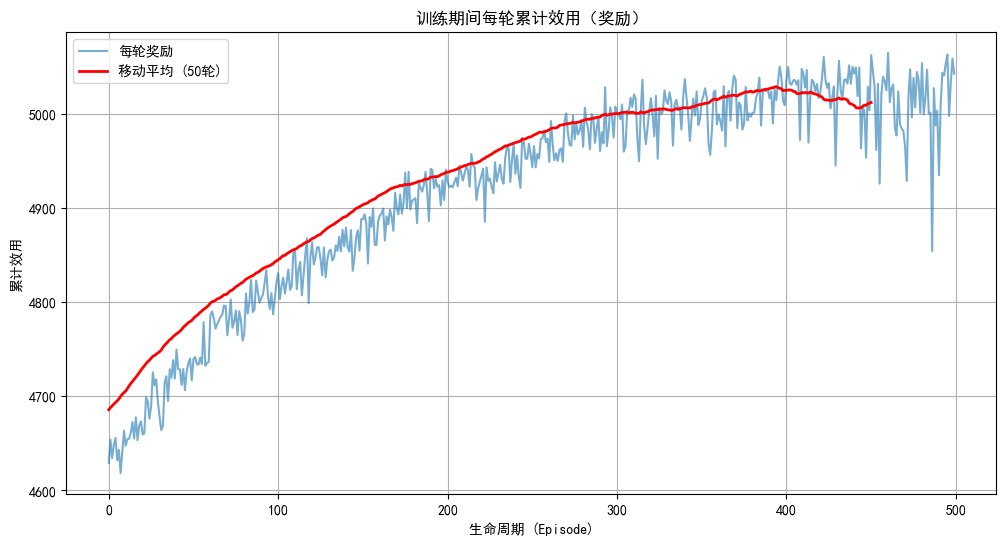

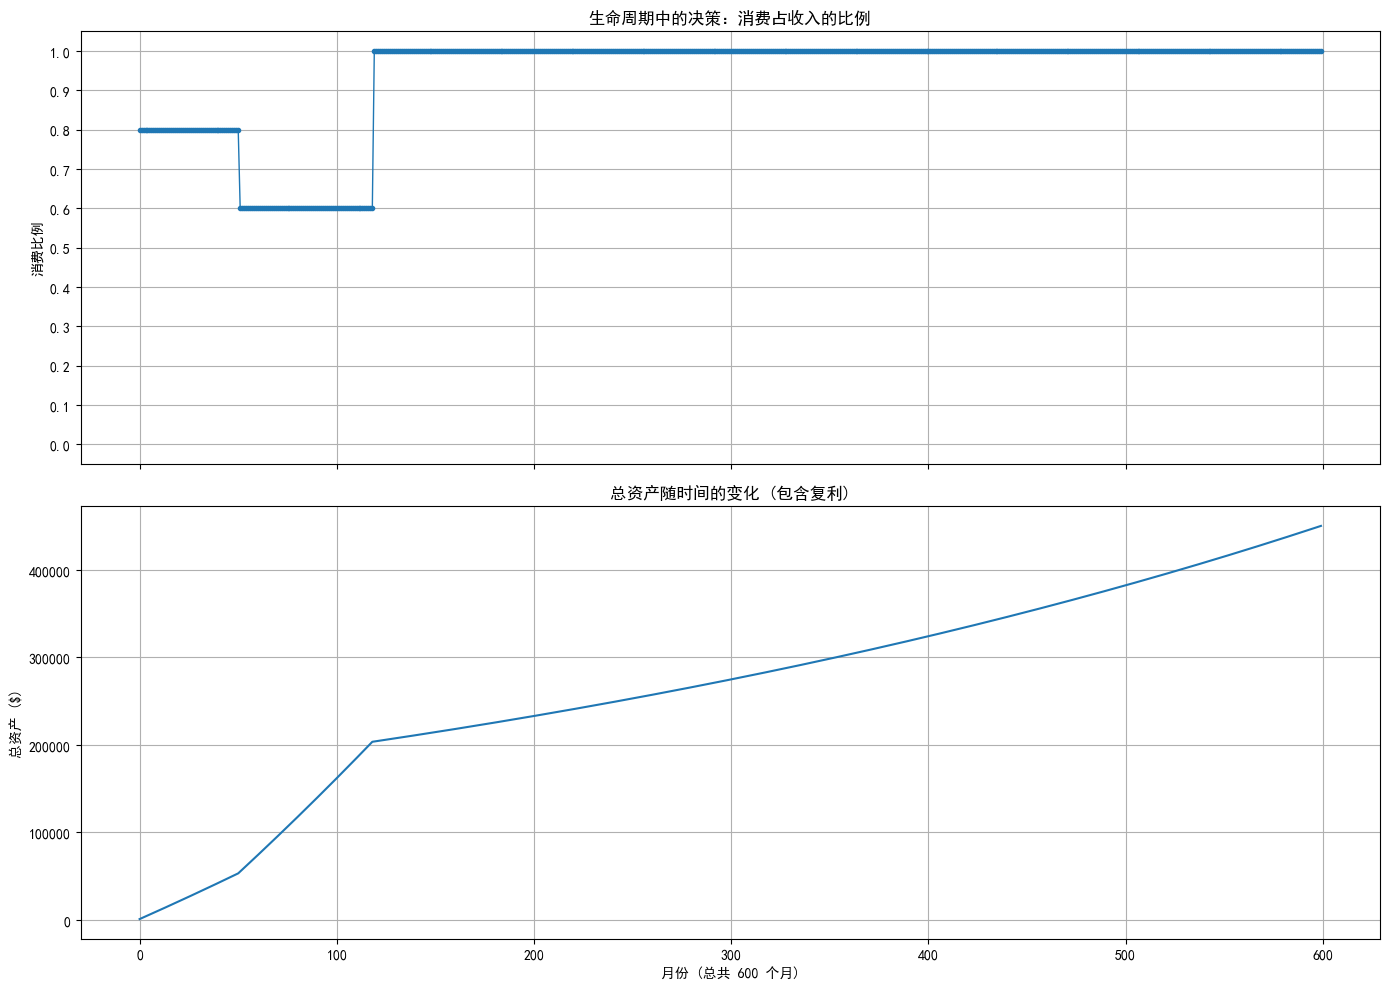

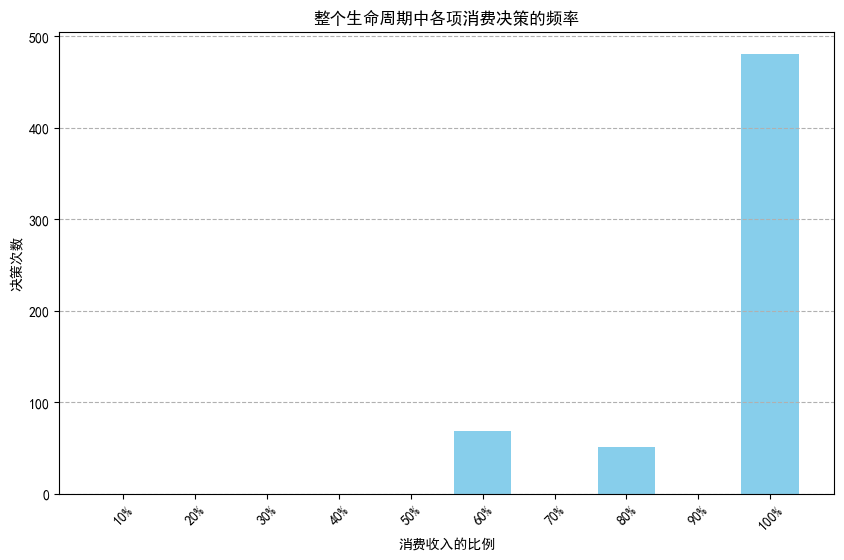

In [170]:
if __name__ == '__main__':
    # 1. 初始化环境和Agent
    print(f"使用设备: {device}")
    env = SimpleEconomyEnv()
    agent = DQNAgent(state_size=env.observation_space_shape[0], action_size=env.action_space_n)
    
    # 2. 训练Agent
    rewards_history = train_agent(agent, env, NUM_EPISODES, TARGET_UPDATE_FREQ)
    
    # 3. 评估学到的策略
    actions, capital_history, final_capital_result = evaluate_policy(agent, env)
    
    # 4. 可视化结果
    visualize_results(rewards_history, actions, capital_history, final_capital_result, env.consumption_levels)

## 修改收入曲线
收入并非一成不变。我考虑了一个三段式的收入曲线：<br>
第一阶段：成长与晋升 (0-19年)，保持5000收入，模拟职业早期的学习和训练。<br>
第二阶段：职业巅峰 (20-39年)，收入达到顶峰，并在此水平上保持稳定，模拟职业生涯的黄金时期。<br>
第三阶段：退休 (40-49年)，认为收入为0。


--- 阶梯式收入曲线验证 ---
工作40年总收入: $3,000,000
工作40年期间的平均月收入: $6,250.00
整个50年期间的平均月收入: $5,000.00


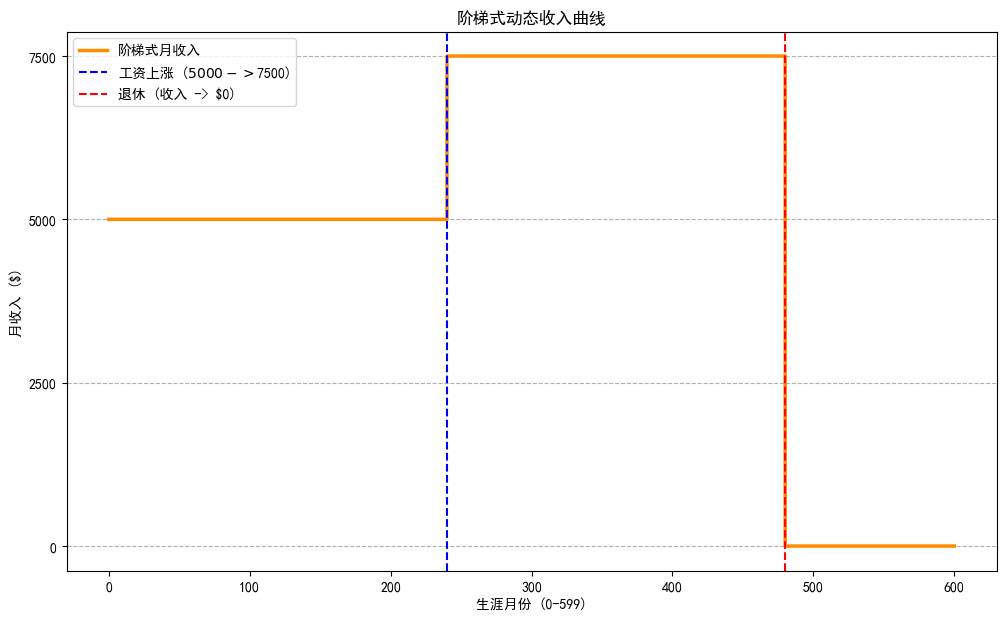

In [27]:
# --- 1. 定义阶梯式收入函数 ---

def get_step_function_income(month_index):
    """
    根据一个三段式的阶梯函数返回月收入。
    - 前20年: $5,000
    - 中20年: $7,500
    - 后10年: $0
    """
    if month_index < 240: # 0-239月 (20年)
        return 5000
    elif month_index < 480: # 240-479月 (20年)
        return 7500
    else: # 480-599月 (10年)
        return 0

# --- 2. 验证函数 ---

def verify_step_function_income_curve():
    """
    验证并可视化新的阶梯式收入曲线
    """
    total_months = 600
    working_months = 480
    
    incomes = [get_step_function_income(t) for t in range(total_months)]
    
    # 计算各种平均值以供分析
    total_lifetime_earnings = sum(incomes)
    avg_over_50_years = total_lifetime_earnings / total_months
    avg_over_40_working_years = total_lifetime_earnings / working_months

    print("\n--- 阶梯式收入曲线验证 ---")
    print(f"工作40年总收入: ${total_lifetime_earnings:,}")
    print(f"工作40年期间的平均月收入: ${avg_over_40_working_years:,.2f}")
    print(f"整个50年期间的平均月收入: ${avg_over_50_years:,.2f}")
    
    plt.rcParams['font.sans-serif'] = ['SimHei'] # 'SimHei' 是黑体
    plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
    # 可视化
    plt.figure(figsize=(12, 7))
    # 使用 'steps-post' 来绘制清晰的阶梯图
    plt.step(range(total_months + 1), incomes + [incomes[-1]], where='post', 
             label='阶梯式月收入', color='darkorange', linewidth=2.5)
    plt.axvline(x=240, color='b', linestyle='--', label='工资上涨 ($5000 -> $7500)')
    plt.axvline(x=480, color='r', linestyle='--', label='退休 (收入 -> $0)')
    plt.title("阶梯式动态收入曲线")
    plt.xlabel("生涯月份 (0-599)")
    plt.ylabel("月收入 ($)")
    plt.yticks([0, 2500, 5000, 7500])
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.show()

# 运行验证
verify_step_function_income_curve()

In [28]:
RETIREMENT_BUDGETS = np.linspace(500, 12500, 10) # 从$500到$12500，共10个等级
BANKRUPTCY_PENALTY = -100 # 破产时的巨大惩罚

TOTAL_MONTHS = 600
WORKING_MONTHS = 480
INTEREST_RATE = (1 + 0.03)**(1/12) - 1
CONSUMPTION_LEVELS = np.linspace(0.1, 1.0, 10) # 工作期用
NUM_ACTIONS = len(CONSUMPTION_LEVELS)


class AdvancedEconomyEnv:
    def __init__(self):
        # ... 初始化参数不变 ...
        self.max_steps = TOTAL_MONTHS
        self.working_months = WORKING_MONTHS
        self.interest_rate = INTEREST_RATE
        self.consumption_levels = CONSUMPTION_LEVELS # 工作期消费比例
        self.retirement_budgets = RETIREMENT_BUDGETS # 退休期预算
        self.bankruptcy_penalty = BANKRUPTCY_PENALTY
        self.action_space_n = NUM_ACTIONS
        self.observation_space_shape = (2,)
        self.reset()

    def get_income(self, month_index):
        """在环境内部调用分段线性收入函数"""

        return get_step_function_income(month_index)

    def reset(self):
        """重置环境到初始状态"""
        self.current_step = 0
        self.capital = 0.0
        # 初始状态: [初始资产, 初始月份]
        return self._get_state()

    def _get_state(self):
        norm_factor = 3_000_000 
        normalized_capital = self.capital / (norm_factor + 1e-6)
        normalized_month = self.current_step / self.max_steps
        return np.array([normalized_capital, normalized_month], dtype=np.float32)

    def step(self, action):
        """
        最终版step函数：工作期(收入分配) + 退休期(预算选择) + 随机冲击
        """
        self.current_step += 1
        done = self.current_step >= self.max_steps
        info = {}
        
        is_working_period = self.current_step <= self.working_months

        if is_working_period:
            # --- 模式一: 工作期决策 (基于收入流) ---

            base_income = self.get_income(self.current_step - 1)
            current_income = base_income
            consumption_ratio = self.consumption_levels[action]
            amount_consumed = current_income * consumption_ratio
            amount_saved = current_income * (1 - consumption_ratio)
            reward = math.log(amount_consumed + 1)
            self.capital += amount_saved
            
        else:
            # --- 模式二: 退休期决策 (选择月度预算) ---
            
            # 1. 根据action，选择一个预算目标
            budget_choice = self.retirement_budgets[action]
            
            # 2. 检查资产是否足以支付预算
            if self.capital >= budget_choice:
                # 资产充足，正常消费
                amount_consumed = budget_choice
                self.capital -= amount_consumed
                reward = math.log(amount_consumed + 1)
            else:
                # 资产不足，破产！
                # 只能消费掉所有剩余的钱
                amount_consumed = self.capital
                self.capital = 0
                # 获得剩余消费的微小效用，但受到巨大惩罚
                reward = math.log(amount_consumed + 1) + self.bankruptcy_penalty
                info['status'] = 'bankrupt'

        # 所有时期的资本都会有利息
        self.capital *= (1 + self.interest_rate)

        if done:
            reward += math.log(self.capital + 1) * alpha
            
        next_state = self._get_state()
        return next_state, reward, done, info

使用设备: cuda
开始训练...
Episode 10/500 | 总奖励: 4849.47 | Epsilon: 0.9511
Episode 20/500 | 总奖励: 4862.59 | Epsilon: 0.9046
Episode 30/500 | 总奖励: 4891.52 | Epsilon: 0.8604
Episode 40/500 | 总奖励: 4913.08 | Epsilon: 0.8183
Episode 50/500 | 总奖励: 4943.37 | Epsilon: 0.7783
Episode 60/500 | 总奖励: 4924.83 | Epsilon: 0.7403
Episode 70/500 | 总奖励: 4957.07 | Epsilon: 0.7041
Episode 80/500 | 总奖励: 4965.34 | Epsilon: 0.6696
Episode 90/500 | 总奖励: 4975.87 | Epsilon: 0.6369
Episode 100/500 | 总奖励: 5016.63 | Epsilon: 0.6058
Episode 110/500 | 总奖励: 5000.02 | Epsilon: 0.5762
Episode 120/500 | 总奖励: 5027.51 | Epsilon: 0.5480
Episode 130/500 | 总奖励: 5059.26 | Epsilon: 0.5212
Episode 140/500 | 总奖励: 5061.42 | Epsilon: 0.4957
Episode 150/500 | 总奖励: 5065.23 | Epsilon: 0.4715
Episode 160/500 | 总奖励: 5066.76 | Epsilon: 0.4484
Episode 170/500 | 总奖励: 5091.52 | Epsilon: 0.4265
Episode 180/500 | 总奖励: 5060.44 | Epsilon: 0.4057
Episode 190/500 | 总奖励: 5113.63 | Epsilon: 0.3858
Episode 200/500 | 总奖励: 5093.57 | Epsilon: 0.3670
Episode 21

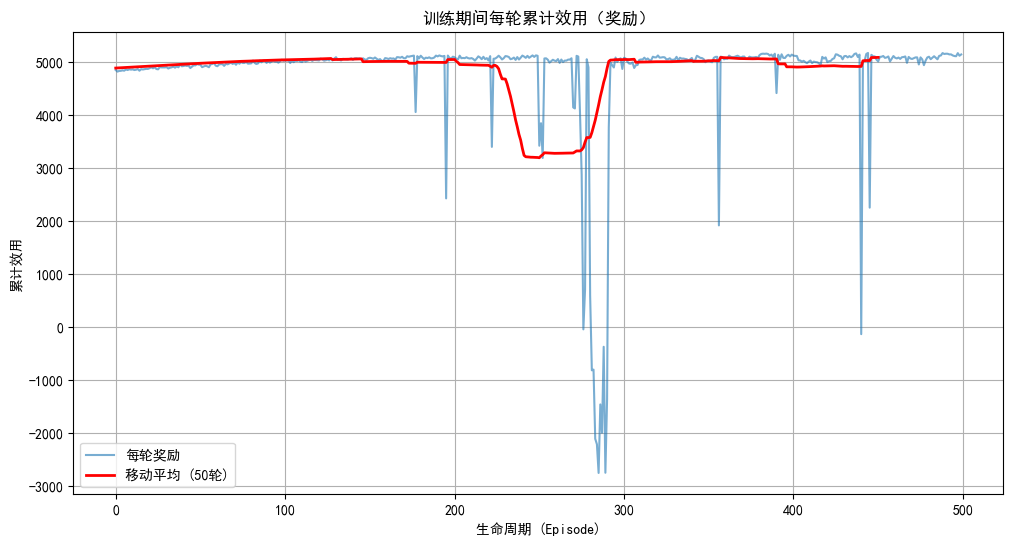

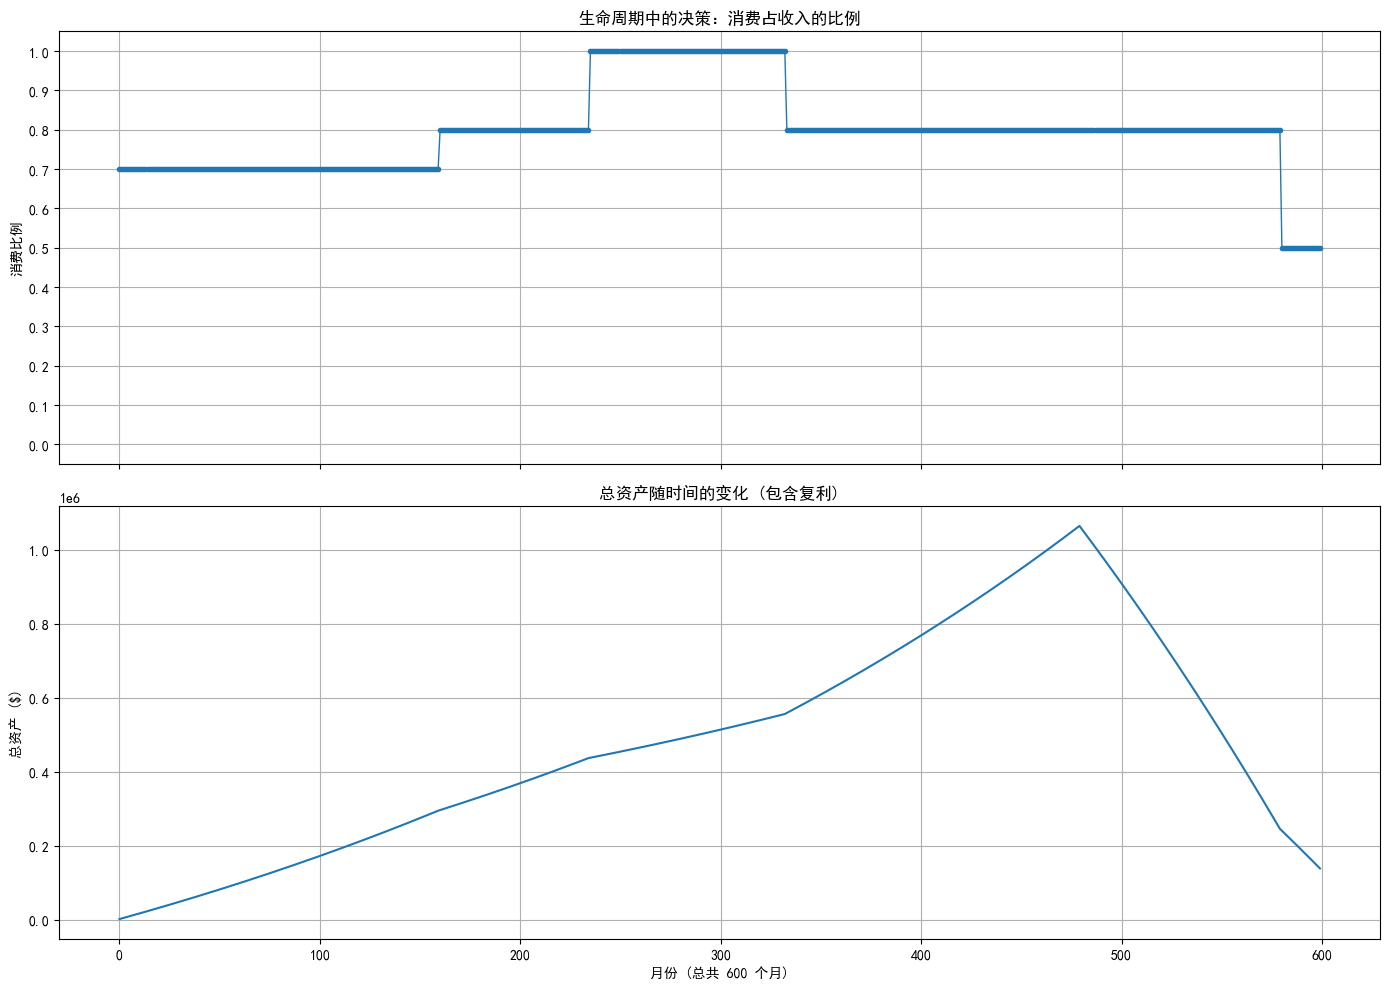

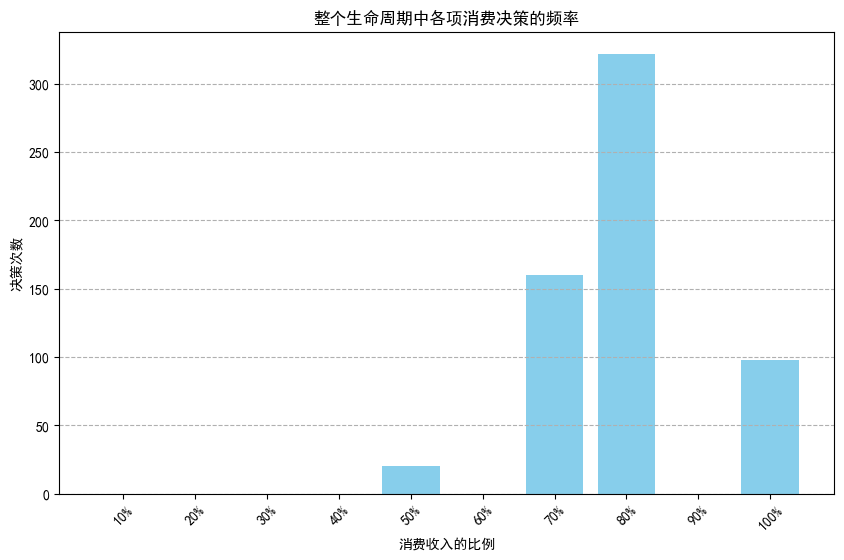

In [89]:
if __name__ == '__main__':
    # 1. 初始化环境和Agent
    print(f"使用设备: {device}")
    env = AdvancedEconomyEnv()
    agent = DQNAgent(state_size=env.observation_space_shape[0], action_size=env.action_space_n)
    
    # 2. 训练Agent
    rewards_history = train_agent(agent, env, NUM_EPISODES, TARGET_UPDATE_FREQ)
    
    # 3. 评估学到的策略
    actions, capital_history, final_capital_result = evaluate_policy(agent, env)
    
    # 4. 可视化结果
    visualize_results(rewards_history, actions, capital_history, final_capital_result, env.consumption_levels)

## 引入负向冲击
我引入两种最经典、最有效的随机冲击：<br>
1、负向收入冲击 (失业)：每个月都有一定的概率失业，当月收入变为零。这考验了Agent对持续收入流的依赖性。<br>
2、负向支出冲击 (紧急情况)：每个月都有更小的概率遇到必须立即支付的紧急情况（如医疗、家庭意外），这会直接消耗一大笔储蓄。这考验了Agent“应急储备金”的厚度。

In [13]:
RETIREMENT_BUDGETS = np.linspace(500, 12500, 10) # 从$500到$12500，共10个等级
BANKRUPTCY_PENALTY = -100 # 破产时的巨大惩罚

TOTAL_MONTHS = 600
WORKING_MONTHS = 480
INTEREST_RATE = (1 + 0.03)**(1/12) - 1
CONSUMPTION_LEVELS = np.linspace(0.1, 1.0, 10) # 工作期用
NUM_ACTIONS = len(CONSUMPTION_LEVELS)

NUM_EPISODES = 1000       # 训练的总生命周期数
BUFFER_SIZE = 50000      # 经验回放池大小

JOB_LOSS_PROBABILITY = 0.01
EMERGENCY_PROBABILITY = 0.005
EMERGENCY_COST = 5000 * 6

class ShockedEconomyEnv:
    def __init__(self):
        # ... 初始化参数不变 ...
        self.max_steps = TOTAL_MONTHS
        self.working_months = WORKING_MONTHS
        self.interest_rate = INTEREST_RATE
        self.consumption_levels = CONSUMPTION_LEVELS # 工作期消费比例
        self.retirement_budgets = RETIREMENT_BUDGETS # 退休期预算
        self.bankruptcy_penalty = BANKRUPTCY_PENALTY
        self.action_space_n = NUM_ACTIONS
        self.observation_space_shape = (2,)
        self.reset()

    def get_income(self, month_index):
        """在环境内部调用分段线性收入函数"""

        return get_step_function_income(month_index)

    def reset(self):
        """重置环境到初始状态"""
        self.current_step = 0
        self.capital = 0.0
        # 初始状态: [初始资产, 初始月份]
        return self._get_state()

    def _get_state(self):
        norm_factor = 3_000_000 
        normalized_capital = self.capital / (norm_factor + 1e-6)
        normalized_month = self.current_step / self.max_steps
        return np.array([normalized_capital, normalized_month], dtype=np.float32)

    def step(self, action):
        """
        优化后的step函数：
        失业冲击仅限于工作期，而紧急支出冲击可以在任何时期发生。
        """
        self.current_step += 1
        done = self.current_step >= self.max_steps
        info = {'shocks': []}
        
        # --- 1. 通用冲击与状态更新 ---
        # 紧急支出冲击可以在任何时期（工作期或退休期）发生。
        if random.random() < EMERGENCY_PROBABILITY:
            self.capital = max(0, self.capital - EMERGENCY_COST)
            # 使用不同的标签来区分冲击发生的时期
            shock_type = 'retirement_emergency' if self.current_step > self.working_months else 'emergency'
            info['shocks'].append(shock_type)

        is_working_period = self.current_step <= self.working_months

        if is_working_period:
            # --- 模式一: 工作期决策 (基于收入) ---
            base_income = self.get_income(self.current_step - 1)
            
            # 2. 失业冲击只能在工作期发生。
            if random.random() < JOB_LOSS_PROBABILITY and base_income > 0:
                current_income = 0
                info['shocks'].append('job_loss')
            else:
                current_income = base_income

            # Agent决定消费收入的比例
            consumption_ratio = self.consumption_levels[action]
            amount_consumed = current_income * consumption_ratio
            amount_saved = current_income * (1 - consumption_ratio)
            
            # 即时奖励是消费带来的效用
            reward = math.log(amount_consumed + 1) 
            self.capital += amount_saved
            
        else:
            # --- 模式二: 退休期决策 (基于预算) ---
            # 没有收入，Agent从其总资本中决定一个每月的消费预算。
            
            # 1. 根据action选择一个预算目标
            budget_choice = self.retirement_budgets[action]
            
            # 2. 检查资本是否足以支付所选预算
            if self.capital >= budget_choice:
                # 资本充足，正常消费
                amount_consumed = budget_choice
                self.capital -= amount_consumed
                reward = math.log(amount_consumed + 1)
            else:
                # 资本不足 - 破产！
                # 只能消费掉所有剩余的钱
                amount_consumed = self.capital
                self.capital = 0
                
                # 从最后的消费中获得微小的效用，但受到巨大的惩罚
                reward = math.log(amount_consumed + 1)  + self.bankruptcy_penalty
                info['status'] = 'bankrupt'
                done = True # 破产会立即结束整个过程

        # --- 3. 所有时期共有的最终更新 ---
        # 在每个周期结束时，资本都会有利息增长
        self.capital *= (1 + self.interest_rate)

        # 如果回合结束，增加剩余资本的效用（遗产动机）
        if done and 'status' not in info: # 如果是因破产而结束，则不增加遗产奖励
            # 'alpha' 参数权衡了最终资本的重要性
            reward += math.log( self.capital + 1) * alpha
            
        next_state = self._get_state()
        return next_state, reward, done, info

In [ ]:
def evaluate_single_capital_policy(agent, env):
    """
    评估函数：专门用于只包含 self.capital 的环境。
    """
    print("\n--- 执行学习到的最优策略 ---")
    state = env.reset()
    agent.epsilon = 0.0  # 关闭探索

    actions_taken = []
    # 【修改】现在我们只记录 env.capital 的历史
    capital_history = [] 

    for t in range(env.max_steps):
        action = agent.choose_action(state)
        actions_taken.append(action)
        
        next_state, _, done, info = env.step(action)
        state = next_state
        
        # 【修改】直接记录环境中的 capital 属性
        capital_history.append(env.capital)
        
        # 如果因为破产等原因需要提前展示，可以加上这个判断
        if info.get('status') == 'bankrupt':
            print(f"在第 {t} 个月破产，评估提前结束。")
            break
            
        if done:
            break
            
    return actions_taken, capital_history, env.capital


使用设备: cuda
开始训练...
Episode 10/1000 | 总奖励: 4804.80 | Epsilon: 0.9511
Episode 20/1000 | 总奖励: 4788.34 | Epsilon: 0.9046
Episode 30/1000 | 总奖励: 4858.21 | Epsilon: 0.8604
Episode 40/1000 | 总奖励: 4858.57 | Epsilon: 0.8183
Episode 50/1000 | 总奖励: 4920.93 | Epsilon: 0.7783
Episode 60/1000 | 总奖励: 4935.15 | Epsilon: 0.7403
Episode 70/1000 | 总奖励: 4917.37 | Epsilon: 0.7041
Episode 80/1000 | 总奖励: 4938.02 | Epsilon: 0.6696
Episode 90/1000 | 总奖励: 4951.68 | Epsilon: 0.6369
Episode 100/1000 | 总奖励: 4952.45 | Epsilon: 0.6058
Episode 110/1000 | 总奖励: 4996.10 | Epsilon: 0.5762
Episode 120/1000 | 总奖励: 4987.65 | Epsilon: 0.5480
Episode 130/1000 | 总奖励: 4975.71 | Epsilon: 0.5212
Episode 140/1000 | 总奖励: 5035.99 | Epsilon: 0.4957
Episode 150/1000 | 总奖励: 5034.39 | Epsilon: 0.4715
Episode 160/1000 | 总奖励: 4999.05 | Epsilon: 0.4484
Episode 170/1000 | 总奖励: 5044.65 | Epsilon: 0.4265
Episode 180/1000 | 总奖励: 5006.99 | Epsilon: 0.4057
Episode 190/1000 | 总奖励: 5017.10 | Epsilon: 0.3858
Episode 200/1000 | 总奖励: 5046.00 | Epsilo

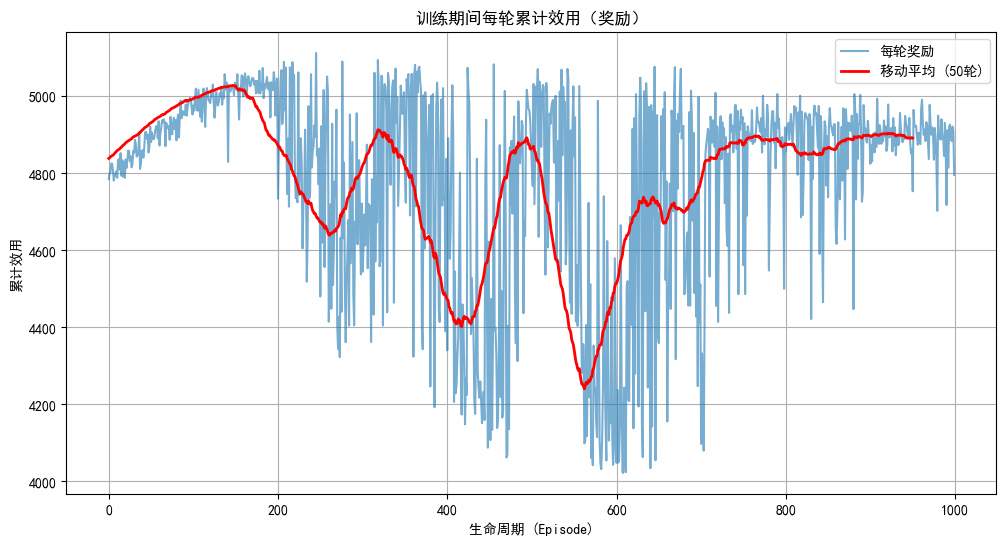

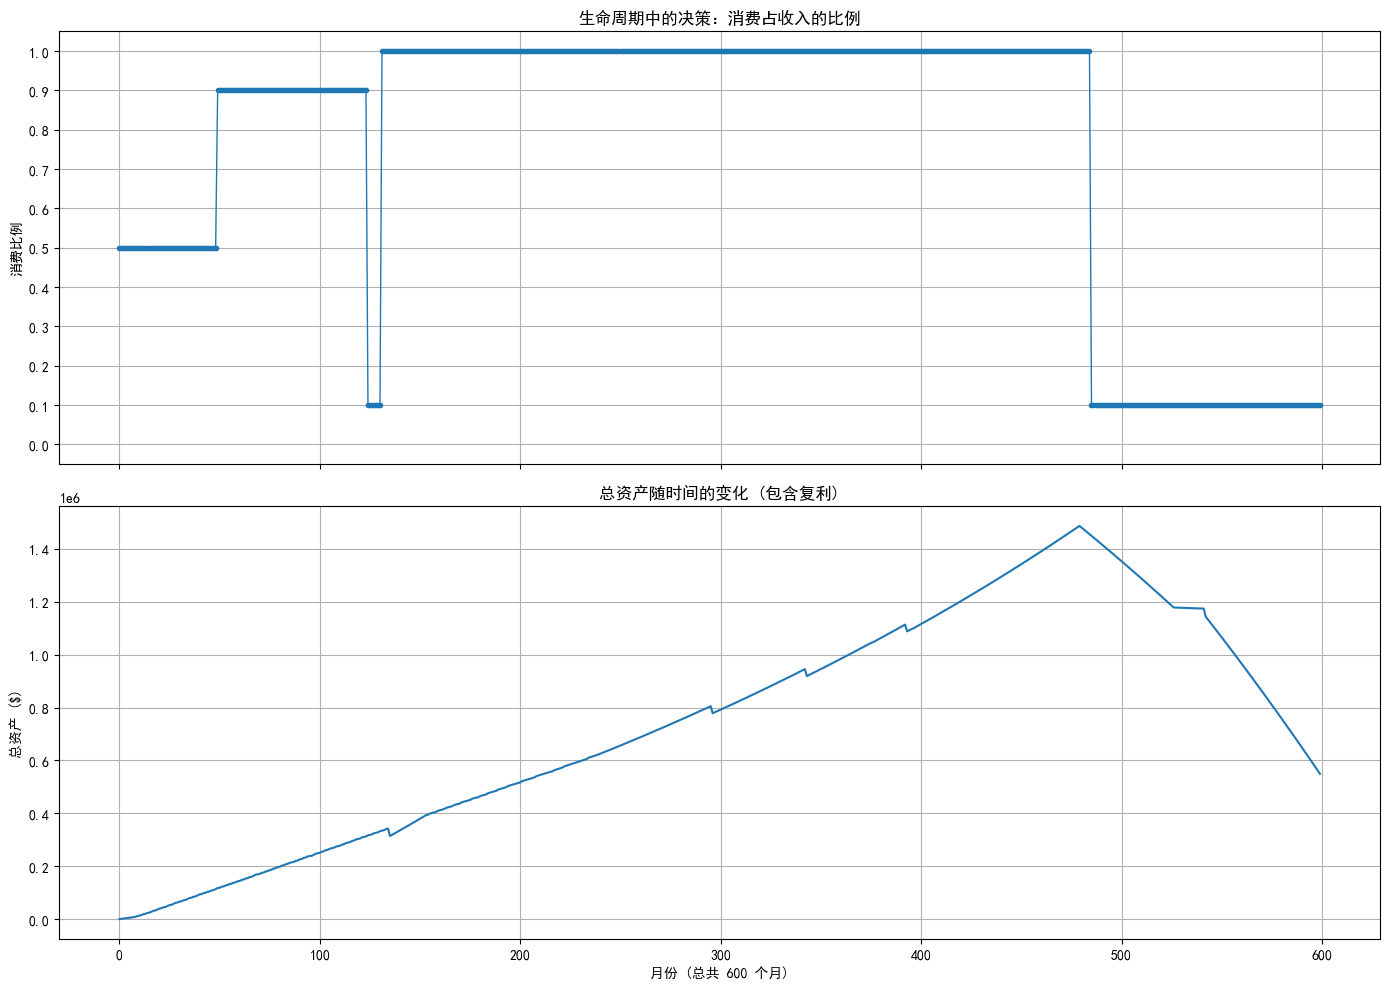

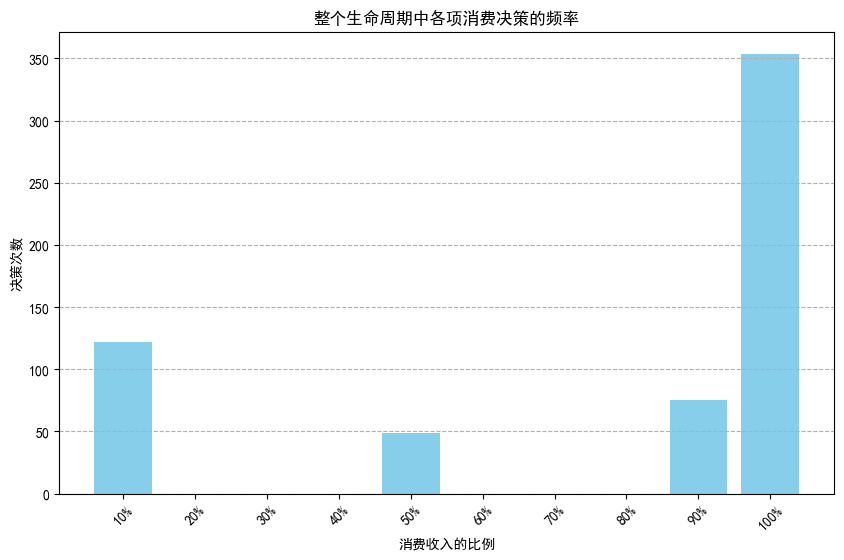

In [120]:
if __name__ == '__main__':
    # 1. 初始化环境和Agent
    print(f"使用设备: {device}")
    env = ShockedEconomyEnv()
    agent = DQNAgent(state_size=env.observation_space_shape[0], action_size=env.action_space_n)
    
    # 2. 训练Agent
    rewards_history = train_agent(agent, env, NUM_EPISODES, TARGET_UPDATE_FREQ)
    
    # 3. 评估学到的策略
    actions, capital_hist, final_capital = evaluate_single_capital_policy(agent, env)
    
    # 4. 可视化结果
    visualize_results(rewards_history, actions, capital_history, final_capital_result, env.consumption_levels)

# 更丰富的投资选择

In [18]:
NUM_EPISODES = 1000      # 训练的总生命周期数
BUFFER_SIZE = 50000      # 经验回放池大小

# 年化回报率
BOND_ANNUAL_RETURN = 0.02
STOCK_AVG_ANNUAL_RETURN = 0.07
STOCK_ANNUAL_VOLATILITY = 0.15
BOND_MONTHLY_RETURN = (1 + BOND_ANNUAL_RETURN)**(1/12) - 1
STOCK_AVG_MONTHLY_RETURN = (1 + STOCK_AVG_ANNUAL_RETURN)**(1/12) - 1
STOCK_MONTHLY_VOLATILITY = STOCK_ANNUAL_VOLATILITY / np.sqrt(12)

# 决策维度参数
CONSUMPTION_RATIOS = np.linspace(0.1, 1.0, 10) # 工作期消费比例
STOCK_ALLOCATION_RATIOS = np.linspace(0, 1.0, 11)   # 储蓄投入股市的比例
RETIREMENT_BUDGETS = np.linspace(2500, 12000, 10) # 退休期预算选择(改为5个以匹配)

NUM_CONSUMPTION_LEVELS = len(CONSUMPTION_RATIOS)
NUM_ALLOCATION_LEVELS = len(STOCK_ALLOCATION_RATIOS)
NUM_ACTIONS = NUM_CONSUMPTION_LEVELS * NUM_ALLOCATION_LEVELS

BANKRUPTCY_PENALTY = -100
TOTAL_MONTHS = 600
WORKING_MONTHS = 480

In [19]:
class DualDecisionEnv:
    def __init__(self):
        self.max_steps = TOTAL_MONTHS
        self.working_months = WORKING_MONTHS
        self.action_space_n = NUM_ACTIONS
        self.observation_space_shape = (3,) # [总资产, 投资占比, 月份]

        self.bond_monthly_return = BOND_MONTHLY_RETURN
        self.stock_avg_monthly_return = STOCK_AVG_MONTHLY_RETURN
        self.stock_monthly_volatility = STOCK_MONTHLY_VOLATILITY
        
        self.consumption_ratios = CONSUMPTION_RATIOS
        self.stock_allocation_ratios = STOCK_ALLOCATION_RATIOS
        self.retirement_budgets = RETIREMENT_BUDGETS
        
        self.bankruptcy_penalty = BANKRUPTCY_PENALTY
        self.reset()

    def get_income(self, month_index):
        return get_step_function_income(month_index)

    def reset(self):
        self.current_step = 0
        self.savings = 0.0
        self.investments = 0.0
        return self._get_state()

    def _get_total_capital(self):
        return self.savings + self.investments

    def _get_state(self):
        total_capital = self._get_total_capital()
        investment_ratio = self.investments / (total_capital + 1e-6)
        norm_factor = 3_000_000
        normalized_capital = total_capital / (norm_factor + 1e-6)
        normalized_month = self.current_step / self.max_steps
        return np.array([normalized_capital, investment_ratio, normalized_month], dtype=np.float32)

    def _decode_action(self, action):
        """将一维动作解码为消费和配置两个决策"""
        consumption_idx = action // NUM_ALLOCATION_LEVELS
        allocation_idx = action % NUM_ALLOCATION_LEVELS
        return consumption_idx, allocation_idx

    def _withdraw_capital(self, amount):
        """
        新增辅助函数：优先从无风险储蓄(savings)中提取资金。
        """
        if self.savings >= amount:
            self.savings -= amount
        else:
            remaining_amount = amount - self.savings
            self.savings = 0
            self.investments = max(0, self.investments - remaining_amount)
    
    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps
        info = {'shocks': []}
        reward = 0

        # 1. 市场先行：现有资产在本月增值
        self.savings *= (1 + self.bond_monthly_return)
        stock_return = np.random.normal(self.stock_avg_monthly_return, self.stock_monthly_volatility)
        self.investments = max(0, self.investments * (1 + stock_return))
        
        # 2. 新增：随机冲击事件
        # 2.1 紧急支出冲击 (任何时期都可能发生)
        if random.random() < EMERGENCY_PROBABILITY:
            # 紧急支出也遵循优先从储蓄中出的原则
            self._withdraw_capital(EMERGENCY_COST)
            info['shocks'].append('emergency')
        
        # 3. 解码动作
        consumption_idx, allocation_idx = self._decode_action(action)
        
        # 4. 根据所处阶段，执行不同决策逻辑
        is_working_period = self.current_step <= self.working_months

        if is_working_period:
            # --- 模式一: 工作期 ---
            base_income = self.get_income(self.current_step - 1)
            
            # 2.2 失业冲击 (只在工作期发生)
            if random.random() < JOB_LOSS_PROBABILITY and base_income > 0:
                current_income = 0
                info['shocks'].append('job_loss')
            else:
                current_income = base_income
            
            # 决策1: 消费 vs 储蓄
            consumption_ratio = self.consumption_ratios[consumption_idx]
            amount_consumed = current_income * consumption_ratio
            amount_saved_total = current_income * (1 - consumption_ratio)
            reward = math.log(amount_consumed + 1)
            
            # 决策2: 储蓄部分如何配置
            stock_allocation_ratio = self.stock_allocation_ratios[allocation_idx]
            to_invest = amount_saved_total * stock_allocation_ratio
            to_save_risk_free = amount_saved_total * (1 - stock_allocation_ratio)
            
            self.savings += to_save_risk_free
            self.investments += to_invest
            
        else: # --- 模式二: 退休期 ---
            total_capital = self._get_total_capital()
            
            # 决策1: 选择消费预算
            budget_choice = self.retirement_budgets[consumption_idx]
            
            if total_capital >= budget_choice:
                amount_consumed = budget_choice
                reward = math.log(amount_consumed + 1)
                
                # 修改：使用新的提款逻辑
                self._withdraw_capital(amount_consumed)

            else: # 破产
                # 强化：使用 max(1, ...) 避免 log(0)
                reward = math.log(total_capital + 1) + self.bankruptcy_penalty
                self.savings, self.investments = 0, 0
                info['status'] = 'bankrupt'
                done = True # 破产立即结束

            # 决策2: 资产再平衡 (仅在未破产时执行)
            if not info.get('status') == 'bankrupt':
                target_stock_allocation = self.stock_allocation_ratios[allocation_idx]
                current_total_capital = self._get_total_capital()
                target_investment_value = current_total_capital * target_stock_allocation
                
                transfer_to_investments = target_investment_value - self.investments
                self.investments += transfer_to_investments
                self.savings -= transfer_to_investments

        # 5. 最终奖励计算
        if done and not info.get('status') == 'bankrupt':
            reward += math.log(self._get_total_capital() + 1) * alpha
            
        next_state = self._get_state()
        return next_state, reward, done, info

    
def visualize_dual_decision_results(
    rewards_history,
    actions_taken,
    portfolio_history, # 这里沿用我们之前的命名
    final_capital_result,
    env
):
    """
    为双重决策环境设计的全新可视化函数 (已修正，更稳健)
    """
    print(f"\n--- 策略评估结果 ---")
    print(f"评估在第 {len(actions_taken)} 个月结束。")
    print(f"最终总资产: ${final_capital_result:,.2f}")

    # --- 图1: 训练奖励曲线 ---
    # ... (这部分代码无需修改，保持原样) ...
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_history, alpha=0.6, label='每轮奖励')
    if len(rewards_history) >= 50:
        moving_avg = np.convolve(rewards_history, np.ones(50)/50, mode='valid')
        plt.plot(moving_avg, color='red', linewidth=2, label='移动平均 (50轮)')
    plt.title("训练期间每轮累计效用（奖励）")
    plt.xlabel("生命周期 (Episode)")
    plt.ylabel("累计效用")
    plt.grid(True)
    plt.legend()
    plt.show()


    # --- 图2: 财富与资产配置随时间变化 ---
    total_capital_hist, savings_hist, investments_hist = zip(*portfolio_history)
    stock_ratio_hist = [inv / (cap + 1e-6) for inv, cap in zip(investments_hist, total_capital_hist)]
    
    # 【修正】X轴的范围应与实际数据长度一致
    x_axis_range = range(len(total_capital_hist))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    ax1.stackplot(x_axis_range, savings_hist, investments_hist, 
                  labels=['储蓄金 (无风险)', '投资金 (风险)'],
                  colors=['skyblue', 'salmon'])
    ax1.plot(x_axis_range, total_capital_hist, color='black', linewidth=2, label='总资产')
    ax1.set_title("财富增长与资产构成")
    ax1.set_ylabel("资产 ($)")
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2.plot(x_axis_range, stock_ratio_hist, color='purple', label='股票占总资产比例')
    ax2.set_title("投资组合风险暴露（股票占比）")
    ax2.set_xlabel(f"生涯月份 (0-{len(actions_taken)-1})")
    ax2.set_ylabel("股票占比")
    ax2.set_ylim([0, 1.05])
    if len(actions_taken) > env.working_months:
        ax2.axvline(x=env.working_months, color='r', linestyle='--', label='退休')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


    # --- 图3: 决策行为分析 ---
    num_allocations = len(env.stock_allocation_ratios)
    
    # 【修正】根据实际的动作数量来分割和解码
    num_working_actions_actual = min(env.working_months, len(actions_taken))
    working_actions = actions_taken[:num_working_actions_actual]
    working_consumption_ratios = [env.consumption_ratios[a // num_allocations] for a in working_actions]
    working_allocation_ratios = [env.stock_allocation_ratios[a % num_allocations] for a in working_actions]
    
    num_retirement_actions_actual = len(actions_taken) - num_working_actions_actual
    if num_retirement_actions_actual > 0:
        retirement_actions = actions_taken[num_working_actions_actual:]
        retirement_budgets = [env.retirement_budgets[a // num_allocations] for a in retirement_actions]
        retirement_rebalance_targets = [env.stock_allocation_ratios[a % num_allocations] for a in retirement_actions]
        retirement_consumption_as_ratio = [b / np.max(env.retirement_budgets) for b in retirement_budgets]

    fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # 上图：消费决策
    ax3.plot(range(num_working_actions_actual), working_consumption_ratios, 
             'bo', markersize=2, label='工作期消费比例')
    if num_retirement_actions_actual > 0:
        # 【修正】这里的X轴和Y轴长度现在保证一致了
        ax3.plot(range(num_working_actions_actual, len(actions_taken)), retirement_consumption_as_ratio,
                 'go', markersize=2, label='退休期预算水平')
    ax3.set_title("消费决策随生命周期的变化")
    ax3.set_ylabel("消费水平 (比例)")
    ax3.legend(loc='upper left')
    ax3.grid(True)

    # 下图：投资配置决策
    ax4.plot(range(num_working_actions_actual), working_allocation_ratios, 
             'bo', markersize=2, label='工作期储蓄的投资比例')
    if num_retirement_actions_actual > 0:
        # 【修正】这里的X轴和Y轴长度现在也保证一致了
        ax4.plot(range(num_working_actions_actual, len(actions_taken)), retirement_rebalance_targets, 
                 'go', markersize=2, label='退休期总资产的目标投资比例')
    ax4.set_title("投资配置决策随生命周期的变化")
    ax4.set_xlabel(f"生涯月份 (0-{len(actions_taken)-1})")
    ax4.set_ylabel("投资于股票的比例")
    if len(actions_taken) > env.working_months:
        ax4.axvline(x=env.working_months, color='r', linestyle='--', label='退休')
    ax4.legend(loc='upper left')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()


def evaluate_policy(agent, env):
    """
    评估训练好的 DQNAgent 在 DualDecisionEnv 环境中的策略。
    此函数已根据您提供的代码进行适配。
    
    Args:
        agent (DQNAgent): 训练好的 agent，它有 .epsilon 属性和 .choose_action() 方法。
        env (DualDecisionEnv): 新的双重决策环境对象。
        
    Returns:
        tuple: (actions_taken, portfolio_history, final_capital)
            - actions_taken (list): 采取的动作列表。
            - portfolio_history (list): 每个时间点的详细资产组合列表 (总资产, 储蓄, 投资)。
            - final_capital (float): 最终的总资产。
    """
    print("\n--- 正在执行学习到的最优策略 ---")
    
    # 1. 重置环境和 Agent
    state = env.reset()
    agent.epsilon = 0.0  # 关闭探索，这和您的代码逻辑一致

    # 2. 初始化数据记录器
    actions_taken = []
    portfolio_history = []
    
    # 记录初始（第0个月初）的资产状态
    # 【适配新环境】使用 _get_total_capital() 方法
    initial_capital = env._get_total_capital()
    portfolio_history.append((initial_capital, env.savings, env.investments))

    # 3. 循环执行每一步，与您之前的 for 循环逻辑保持一致
    for t in range(env.max_steps):
        # 使用您的 agent 的方法来选择动作
        action = agent.choose_action(state)
        actions_taken.append(action)
        
        # 在环境中执行一步
        next_state, _, done, info = env.step(action)
        
        # 更新状态
        state = next_state
        
        # 【适配新环境】记录当前（本月结束后）的详细资产状态
        current_total_capital = env._get_total_capital()
        portfolio_history.append((current_total_capital, env.savings, env.investments))
        
        # 如果生命周期提前结束（例如破产），则跳出循环
        if done:
            status = info.get('status', '达到最大时长') # 获取结束原因
            print(f"评估在第 {t+1} 个月结束。原因: {status}")
            break
            
    # 4. 从历史记录中获取最终资本
    final_capital = portfolio_history[-1][0]
    
    # 5. 返回与可视化函数兼容的结果
    return actions_taken, portfolio_history, final_capital

开始训练...
Episode 10/1000 | 总奖励: 4862.71 | Epsilon: 0.9511
Episode 20/1000 | 总奖励: 4857.37 | Epsilon: 0.9046
Episode 30/1000 | 总奖励: 4882.90 | Epsilon: 0.8604
Episode 40/1000 | 总奖励: 4886.38 | Epsilon: 0.8183
Episode 50/1000 | 总奖励: 4916.35 | Epsilon: 0.7783
Episode 60/1000 | 总奖励: 4933.84 | Epsilon: 0.7403
Episode 70/1000 | 总奖励: 4924.92 | Epsilon: 0.7041
Episode 80/1000 | 总奖励: 4938.07 | Epsilon: 0.6696
Episode 90/1000 | 总奖励: 4967.56 | Epsilon: 0.6369
Episode 100/1000 | 总奖励: 4927.16 | Epsilon: 0.6058
Episode 110/1000 | 总奖励: 4976.58 | Epsilon: 0.5762
Episode 120/1000 | 总奖励: 5034.58 | Epsilon: 0.5480
Episode 130/1000 | 总奖励: 4973.27 | Epsilon: 0.5212
Episode 140/1000 | 总奖励: 5047.68 | Epsilon: 0.4957
Episode 150/1000 | 总奖励: 4999.19 | Epsilon: 0.4715
Episode 160/1000 | 总奖励: 5001.49 | Epsilon: 0.4484
Episode 170/1000 | 总奖励: 5031.14 | Epsilon: 0.4265
Episode 180/1000 | 总奖励: 5067.58 | Epsilon: 0.4057
Episode 190/1000 | 总奖励: 5020.57 | Epsilon: 0.3858
Episode 200/1000 | 总奖励: 4912.91 | Epsilon: 0.3670
E

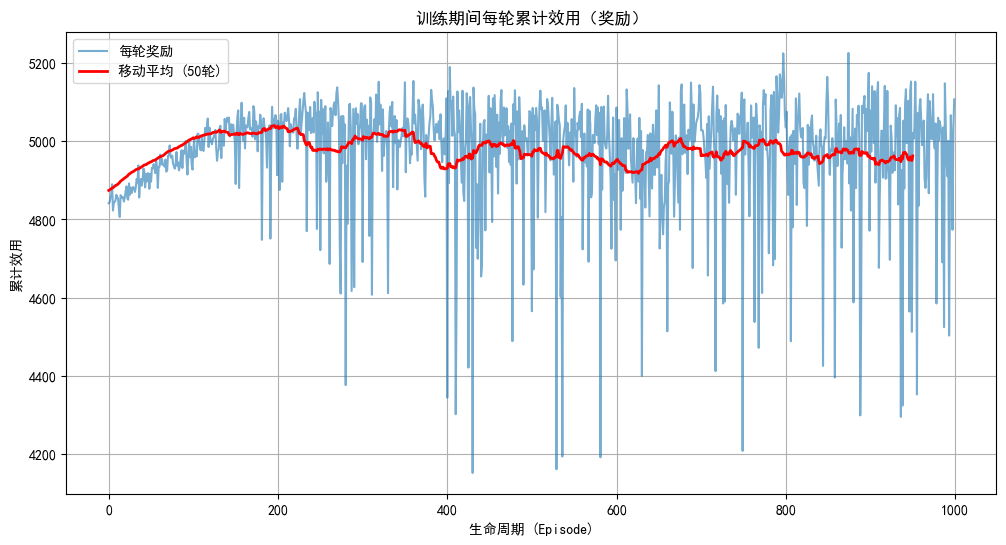

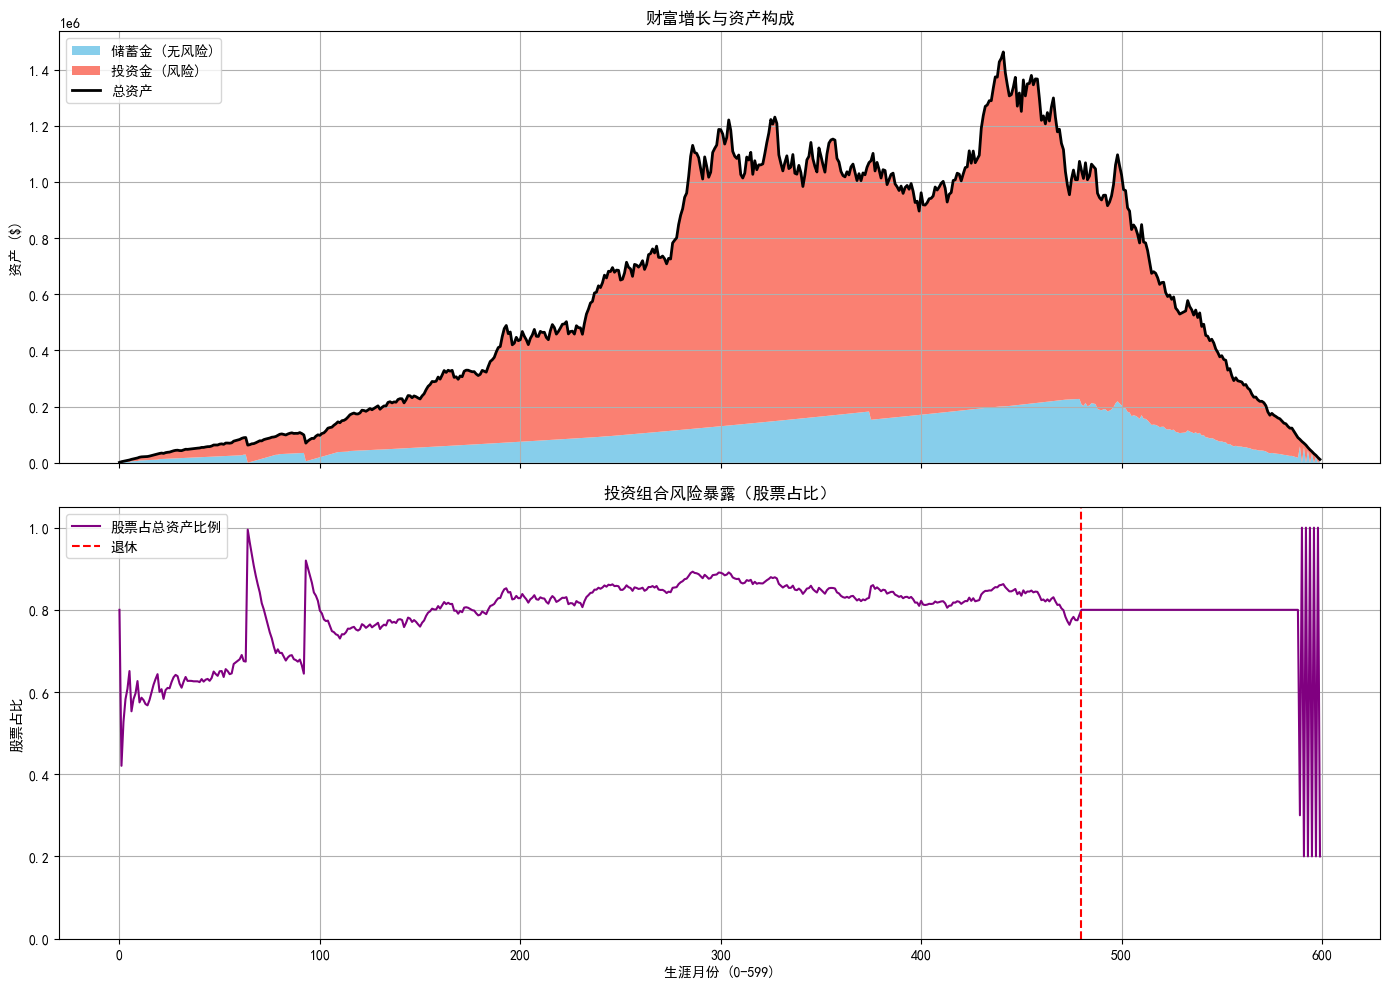

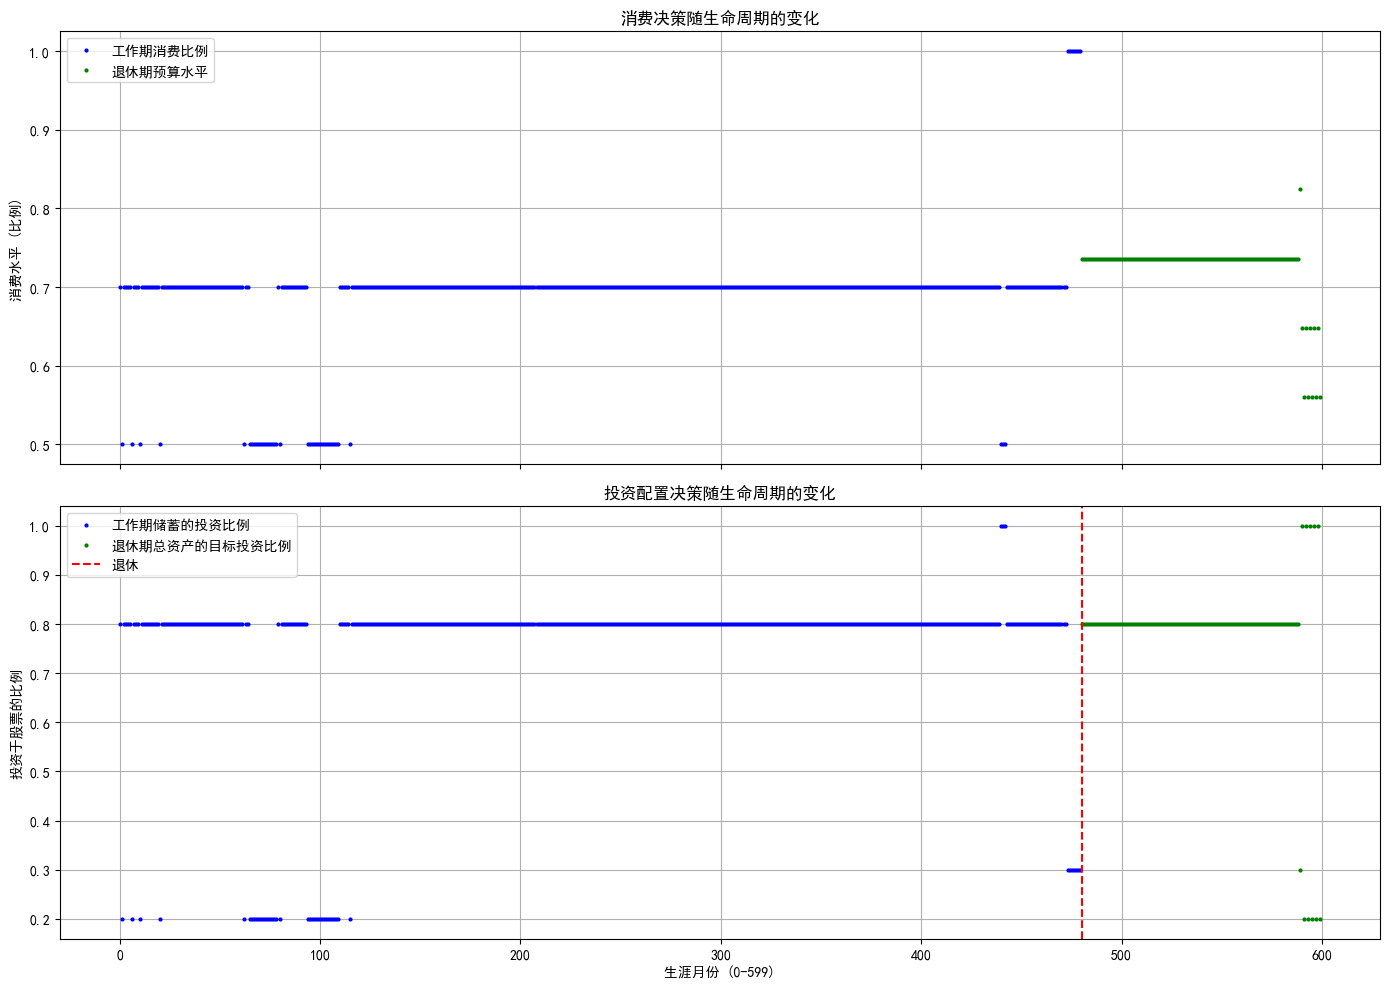

In [129]:
if __name__ == '__main__':
    # 1. 初始化环境和Agent
    env = DualDecisionEnv() # 使用新的环境
    agent = DQNAgent(state_size=env.observation_space_shape[0], action_size=env.action_space_n)
    
    # 2. 训练Agent
    rewards_history = train_agent(agent, env, NUM_EPISODES, TARGET_UPDATE_FREQ)
    
    # 3. 评估学到的策略
    actions, capital_hist, final_capital = evaluate_policy(agent, env)
    
    # 4. 【修改】调用新的可视化函数
    visualize_dual_decision_results(rewards_history, actions, capital_hist, final_capital, env)

## 加入黑天鹅事件

In [20]:
BLACK_SWAN_PROBABILITY = 0.005 #  0.5% 的概率，大约200个月发生一次

In [21]:
NUM_EPISODES = 1000      # 训练的总生命周期数
BUFFER_SIZE = 50000      # 经验回放池大小
class DualDecisionEnv:
    def __init__(self):
        self.max_steps = TOTAL_MONTHS
        self.working_months = WORKING_MONTHS
        self.action_space_n = NUM_ACTIONS
        self.observation_space_shape = (3,) # [总资产, 投资占比, 月份]

        self.bond_monthly_return = BOND_MONTHLY_RETURN
        self.stock_avg_monthly_return = STOCK_AVG_MONTHLY_RETURN
        self.stock_monthly_volatility = STOCK_MONTHLY_VOLATILITY
        
        self.consumption_ratios = CONSUMPTION_RATIOS
        self.stock_allocation_ratios = STOCK_ALLOCATION_RATIOS
        self.retirement_budgets = RETIREMENT_BUDGETS
        
        self.bankruptcy_penalty = BANKRUPTCY_PENALTY
        self.reset()

    def get_income(self, month_index):
        return get_step_function_income(month_index)

    def reset(self):
        self.current_step = 0
        self.savings = 0.0
        self.investments = 0.0
        return self._get_state()

    def _get_total_capital(self):
        return self.savings + self.investments

    def _get_state(self):
        total_capital = self._get_total_capital()
        investment_ratio = self.investments / (total_capital + 1e-6)
        norm_factor = 3_000_000
        normalized_capital = total_capital / (norm_factor + 1e-6)
        normalized_month = self.current_step / self.max_steps
        return np.array([normalized_capital, investment_ratio, normalized_month], dtype=np.float32)

    def _decode_action(self, action):
        """将一维动作解码为消费和配置两个决策"""
        consumption_idx = action // NUM_ALLOCATION_LEVELS
        allocation_idx = action % NUM_ALLOCATION_LEVELS
        return consumption_idx, allocation_idx

    def _withdraw_capital(self, amount):
        """
        新增辅助函数：优先从无风险储蓄(savings)中提取资金。
        """
        if self.savings >= amount:
            self.savings -= amount
        else:
            remaining_amount = amount - self.savings
            self.savings = 0
            self.investments = max(0, self.investments - remaining_amount)
    
    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps
        info = {'shocks': []}
        reward = 0

        # 1. 市场先行：现有资产在本月增值


        self.savings *= (1 + self.bond_monthly_return)
        stock_return = np.random.normal(self.stock_avg_monthly_return, self.stock_monthly_volatility)
        if random.random() < BLACK_SWAN_PROBABILITY:
            stock_return = -0.4 # 黑天鹅事件
        self.investments = max(0, self.investments * (1 + stock_return))
        
        # 2. 新增：随机冲击事件
        # 2.1 紧急支出冲击 (任何时期都可能发生)
        if random.random() < EMERGENCY_PROBABILITY:
            # 紧急支出也遵循优先从储蓄中出的原则
            self._withdraw_capital(EMERGENCY_COST)
            info['shocks'].append('emergency')
        
        # 3. 解码动作
        consumption_idx, allocation_idx = self._decode_action(action)
        
        # 4. 根据所处阶段，执行不同决策逻辑
        is_working_period = self.current_step <= self.working_months

        if is_working_period:
            # --- 模式一: 工作期 ---
            base_income = self.get_income(self.current_step - 1)
            
            # 2.2 失业冲击 (只在工作期发生)
            if random.random() < JOB_LOSS_PROBABILITY and base_income > 0:
                current_income = 0
                info['shocks'].append('job_loss')
            else:
                current_income = base_income
            
            # 决策1: 消费 vs 储蓄
            consumption_ratio = self.consumption_ratios[consumption_idx]
            amount_consumed = current_income * consumption_ratio
            amount_saved_total = current_income * (1 - consumption_ratio)
            reward = math.log(amount_consumed + 1)
            
            # 决策2: 储蓄部分如何配置
            stock_allocation_ratio = self.stock_allocation_ratios[allocation_idx]
            to_invest = amount_saved_total * stock_allocation_ratio
            to_save_risk_free = amount_saved_total * (1 - stock_allocation_ratio)
            
            self.savings += to_save_risk_free
            self.investments += to_invest
            
        else: # --- 模式二: 退休期 ---
            total_capital = self._get_total_capital()
            
            # 决策1: 选择消费预算
            budget_choice = self.retirement_budgets[consumption_idx]
            
            if total_capital >= budget_choice:
                amount_consumed = budget_choice
                reward = math.log(amount_consumed + 1)
                
                # 修改：使用新的提款逻辑
                self._withdraw_capital(amount_consumed)

            else: # 破产
                # 强化：使用 max(1, ...) 避免 log(0)
                reward = math.log(total_capital + 1) + self.bankruptcy_penalty
                self.savings, self.investments = 0, 0
                info['status'] = 'bankrupt'
                done = True # 破产立即结束

            # 决策2: 资产再平衡 (仅在未破产时执行)
            if not info.get('status') == 'bankrupt':
                target_stock_allocation = self.stock_allocation_ratios[allocation_idx]
                current_total_capital = self._get_total_capital()
                target_investment_value = current_total_capital * target_stock_allocation
                
                transfer_to_investments = target_investment_value - self.investments
                self.investments += transfer_to_investments
                self.savings -= transfer_to_investments

        # 5. 最终奖励计算
        if done and not info.get('status') == 'bankrupt':
            reward += math.log(self._get_total_capital() + 1) * alpha
            
        next_state = self._get_state()
        return next_state, reward, done, info


开始训练...
Episode 10/1000 | 总奖励: 4881.09 | Epsilon: 0.9511
Episode 20/1000 | 总奖励: 4888.75 | Epsilon: 0.9046
Episode 30/1000 | 总奖励: 4900.81 | Epsilon: 0.8604
Episode 40/1000 | 总奖励: 4891.47 | Epsilon: 0.8183
Episode 50/1000 | 总奖励: 4672.11 | Epsilon: 0.7783
Episode 60/1000 | 总奖励: 4941.29 | Epsilon: 0.7403
Episode 70/1000 | 总奖励: 4948.56 | Epsilon: 0.7041
Episode 80/1000 | 总奖励: 4976.19 | Epsilon: 0.6696
Episode 90/1000 | 总奖励: 4775.08 | Epsilon: 0.6369
Episode 100/1000 | 总奖励: 4511.95 | Epsilon: 0.6058
Episode 110/1000 | 总奖励: 4997.27 | Epsilon: 0.5762
Episode 120/1000 | 总奖励: 4994.19 | Epsilon: 0.5480
Episode 130/1000 | 总奖励: 4961.74 | Epsilon: 0.5212
Episode 140/1000 | 总奖励: 5033.85 | Epsilon: 0.4957
Episode 150/1000 | 总奖励: 5044.21 | Epsilon: 0.4715
Episode 160/1000 | 总奖励: 5031.71 | Epsilon: 0.4484
Episode 170/1000 | 总奖励: 4553.68 | Epsilon: 0.4265
Episode 180/1000 | 总奖励: 4714.06 | Epsilon: 0.4057
Episode 190/1000 | 总奖励: 4650.13 | Epsilon: 0.3858
Episode 200/1000 | 总奖励: 4690.54 | Epsilon: 0.3670
E

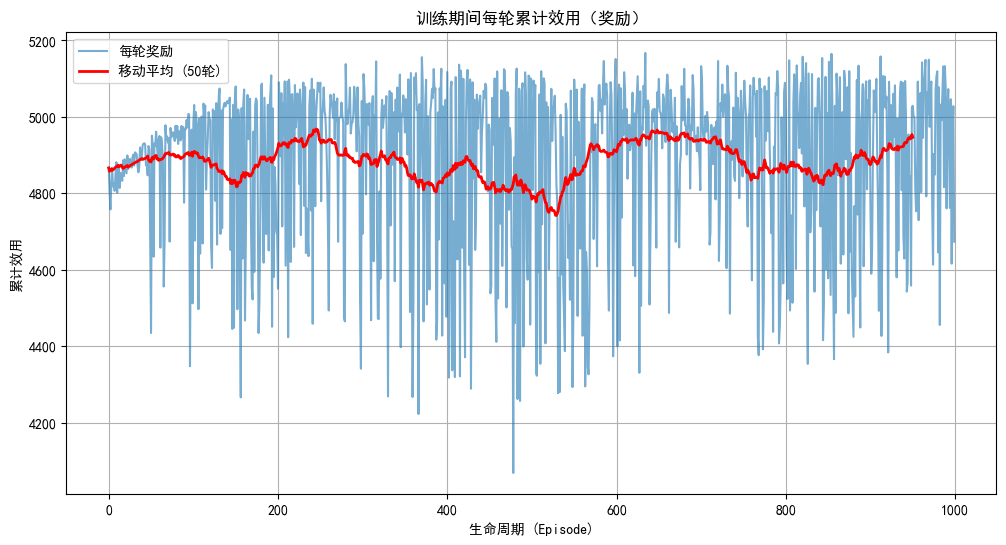

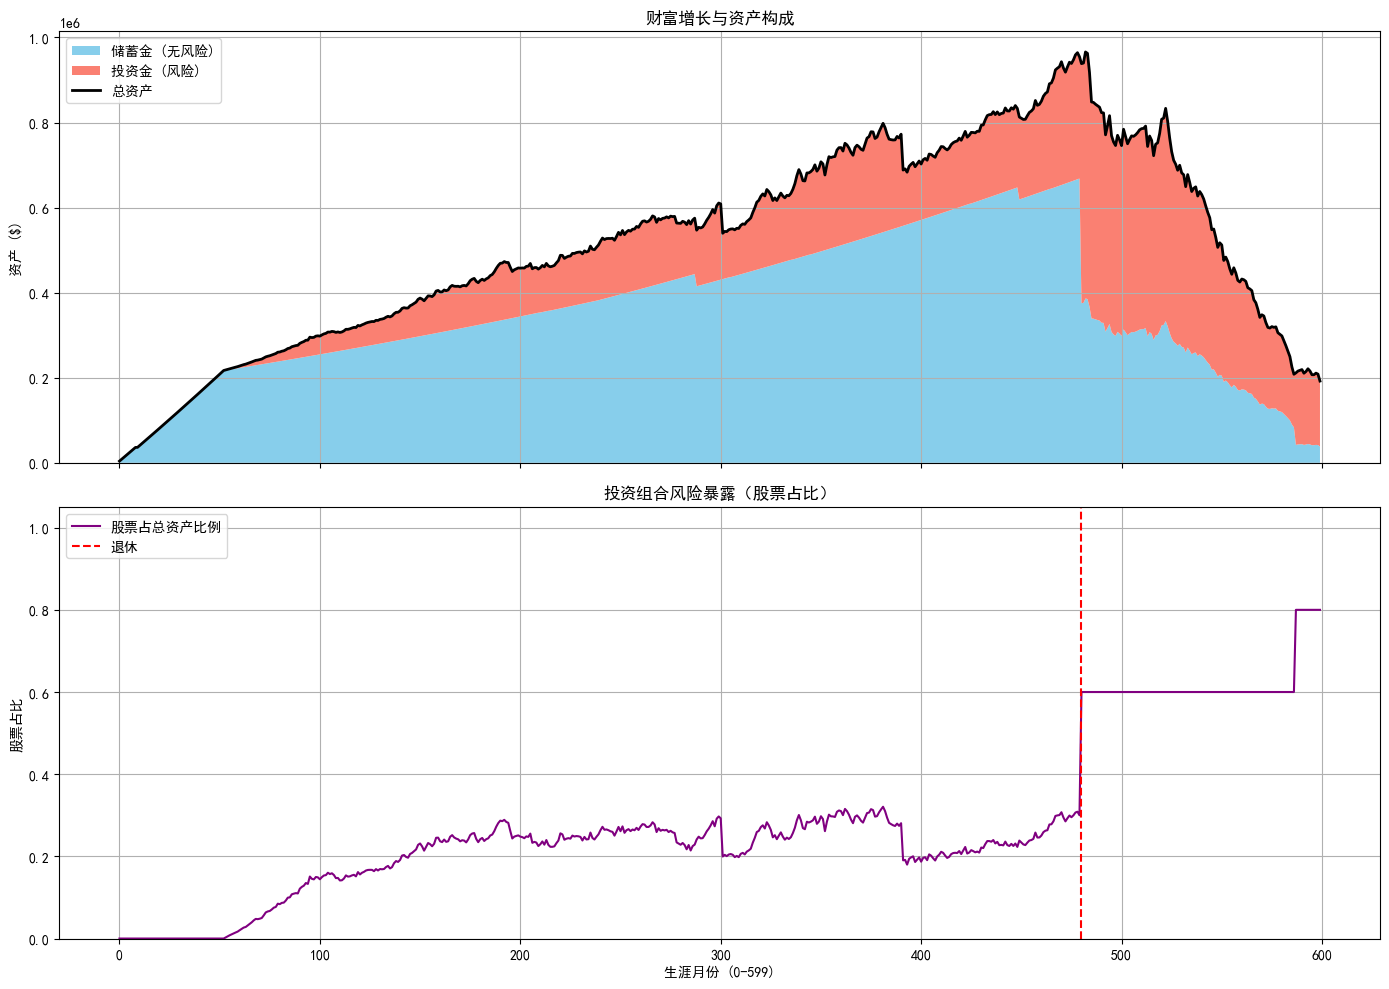

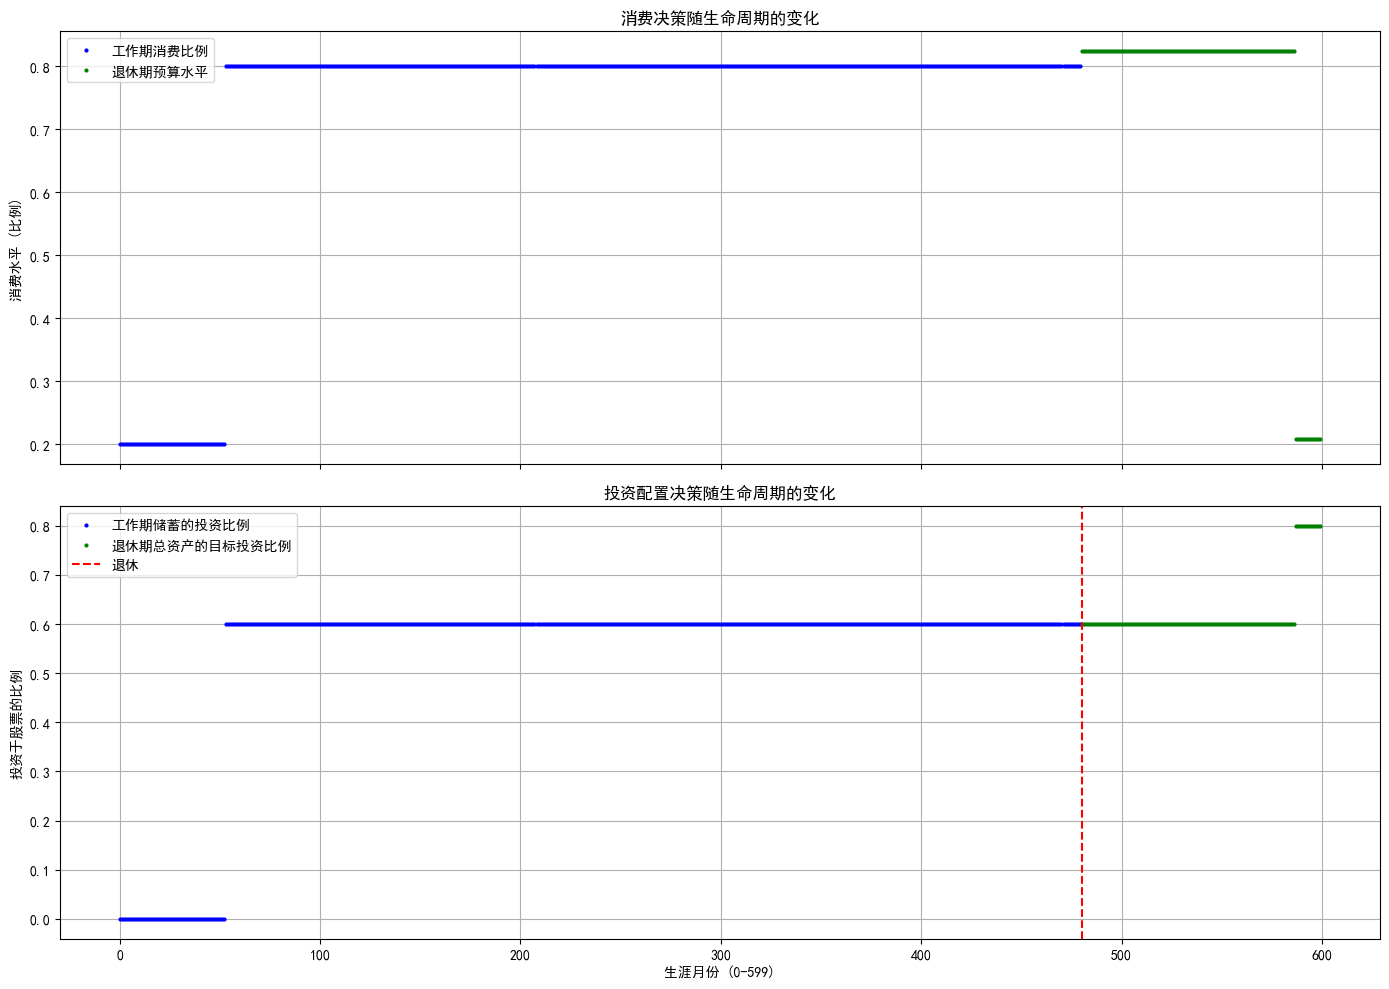

In [132]:
if __name__ == '__main__':
    # 1. 初始化环境和Agent
    env = DualDecisionEnv() # 使用新的环境
    agent = DQNAgent(state_size=env.observation_space_shape[0], action_size=env.action_space_n)
    
    # 2. 训练Agent
    rewards_history = train_agent(agent, env, NUM_EPISODES, TARGET_UPDATE_FREQ)
    
    # 3. 评估学到的策略
    actions, capital_hist, final_capital = evaluate_policy(agent, env)
    
    # 4. 【修改】调用新的可视化函数
    visualize_dual_decision_results(rewards_history, actions, capital_hist, final_capital, env)

# 多目标问题

## 加入遗产效用

In [29]:
NUM_EPISODES = 1000      # 训练的总生命周期数
BUFFER_SIZE = 50000      # 经验回放池大小
alpha = 1
class DualDecisionEnv:
    def __init__(self):
        self.max_steps = TOTAL_MONTHS
        self.working_months = WORKING_MONTHS
        self.action_space_n = NUM_ACTIONS
        self.observation_space_shape = (3,) # [总资产, 投资占比, 月份]

        self.bond_monthly_return = BOND_MONTHLY_RETURN
        self.stock_avg_monthly_return = STOCK_AVG_MONTHLY_RETURN
        self.stock_monthly_volatility = STOCK_MONTHLY_VOLATILITY
        
        self.consumption_ratios = CONSUMPTION_RATIOS
        self.stock_allocation_ratios = STOCK_ALLOCATION_RATIOS
        self.retirement_budgets = RETIREMENT_BUDGETS
        
        self.bankruptcy_penalty = BANKRUPTCY_PENALTY
        self.reset()

    def get_income(self, month_index):
        return get_step_function_income(month_index)

    def reset(self):
        self.current_step = 0
        self.savings = 0.0
        self.investments = 0.0
        return self._get_state()

    def _get_total_capital(self):
        return self.savings + self.investments

    def _get_state(self):
        total_capital = self._get_total_capital()
        investment_ratio = self.investments / (total_capital + 1e-6)
        norm_factor = 3_000_000
        normalized_capital = total_capital / (norm_factor + 1e-6)
        normalized_month = self.current_step / self.max_steps
        return np.array([normalized_capital, investment_ratio, normalized_month], dtype=np.float32)

    def _decode_action(self, action):
        """将一维动作解码为消费和配置两个决策"""
        consumption_idx = action // NUM_ALLOCATION_LEVELS
        allocation_idx = action % NUM_ALLOCATION_LEVELS
        return consumption_idx, allocation_idx

    def _withdraw_capital(self, amount):
        """
        新增辅助函数：优先从无风险储蓄(savings)中提取资金。
        """
        if self.savings >= amount:
            self.savings -= amount
        else:
            remaining_amount = amount - self.savings
            self.savings = 0
            self.investments = max(0, self.investments - remaining_amount)
    
    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps
        info = {'shocks': []}
        reward = 0

        # 1. 市场先行：现有资产在本月增值


        self.savings *= (1 + self.bond_monthly_return)
        stock_return = np.random.normal(self.stock_avg_monthly_return, self.stock_monthly_volatility)
        if random.random() < BLACK_SWAN_PROBABILITY:
            stock_return = -0.4 # 黑天鹅事件
        self.investments = max(0, self.investments * (1 + stock_return))
        
        # 2. 新增：随机冲击事件
        # 2.1 紧急支出冲击 (任何时期都可能发生)
        if random.random() < EMERGENCY_PROBABILITY:
            # 紧急支出也遵循优先从储蓄中出的原则
            self._withdraw_capital(EMERGENCY_COST)
            info['shocks'].append('emergency')
        
        # 3. 解码动作
        consumption_idx, allocation_idx = self._decode_action(action)
        
        # 4. 根据所处阶段，执行不同决策逻辑
        is_working_period = self.current_step <= self.working_months

        if is_working_period:
            # --- 模式一: 工作期 ---
            base_income = self.get_income(self.current_step - 1)
            
            # 2.2 失业冲击 (只在工作期发生)
            if random.random() < JOB_LOSS_PROBABILITY and base_income > 0:
                current_income = 0
                info['shocks'].append('job_loss')
            else:
                current_income = base_income
            
            # 决策1: 消费 vs 储蓄
            consumption_ratio = self.consumption_ratios[consumption_idx]
            amount_consumed = current_income * consumption_ratio
            amount_saved_total = current_income * (1 - consumption_ratio)
            reward = math.log(amount_consumed + 1)
            
            # 决策2: 储蓄部分如何配置
            stock_allocation_ratio = self.stock_allocation_ratios[allocation_idx]
            to_invest = amount_saved_total * stock_allocation_ratio
            to_save_risk_free = amount_saved_total * (1 - stock_allocation_ratio)
            
            self.savings += to_save_risk_free
            self.investments += to_invest
            
        else: # --- 模式二: 退休期 ---
            total_capital = self._get_total_capital()
            
            # 决策1: 选择消费预算
            budget_choice = self.retirement_budgets[consumption_idx]
            
            if total_capital >= budget_choice:
                amount_consumed = budget_choice
                reward = math.log(amount_consumed + 1)
                
                # 修改：使用新的提款逻辑
                self._withdraw_capital(amount_consumed)

            else: # 破产
                # 强化：使用 max(1, ...) 避免 log(0)
                reward = math.log(total_capital + 1) + self.bankruptcy_penalty
                self.savings, self.investments = 0, 0
                info['status'] = 'bankrupt'
                done = True # 破产立即结束

            # 决策2: 资产再平衡 (仅在未破产时执行)
            if not info.get('status') == 'bankrupt':
                target_stock_allocation = self.stock_allocation_ratios[allocation_idx]
                current_total_capital = self._get_total_capital()
                target_investment_value = current_total_capital * target_stock_allocation
                
                transfer_to_investments = target_investment_value - self.investments
                self.investments += transfer_to_investments
                self.savings -= transfer_to_investments

        # 5. 最终奖励计算
        if done and not info.get('status') == 'bankrupt':
            reward += math.log(self._get_total_capital() + 1) * alpha
            
        next_state = self._get_state()
        return next_state, reward, done, info

In [ ]:
if __name__ == '__main__':
    # 1. 初始化环境和Agent
    env = DualDecisionEnv() # 使用新的环境
    agent = DQNAgent(state_size=env.observation_space_shape[0], action_size=env.action_space_n)
    
    # 2. 训练Agent
    rewards_history = train_agent(agent, env, NUM_EPISODES, TARGET_UPDATE_FREQ)
    


--- 正在执行学习到的最优策略 ---
评估在第 600 个月结束。原因: 达到最大时长

--- 策略评估结果 ---
评估在第 600 个月结束。
最终总资产: $5,418,019.52


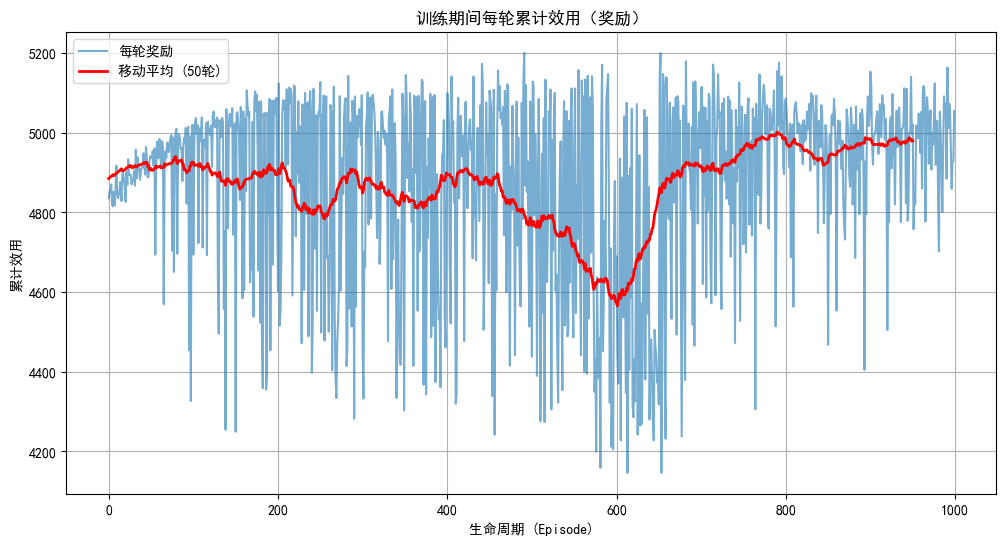

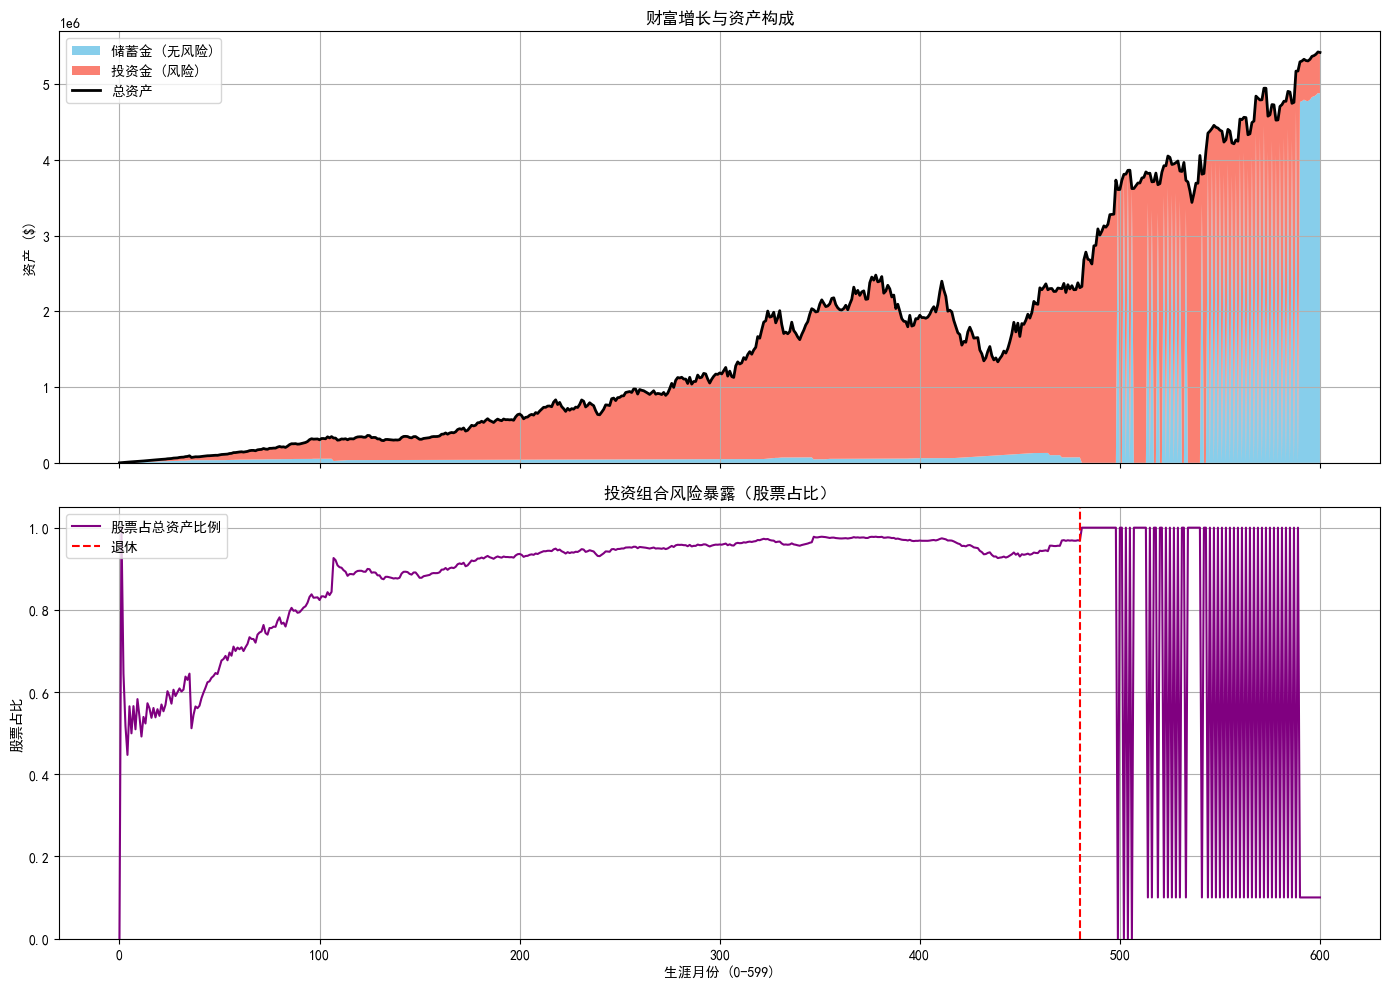

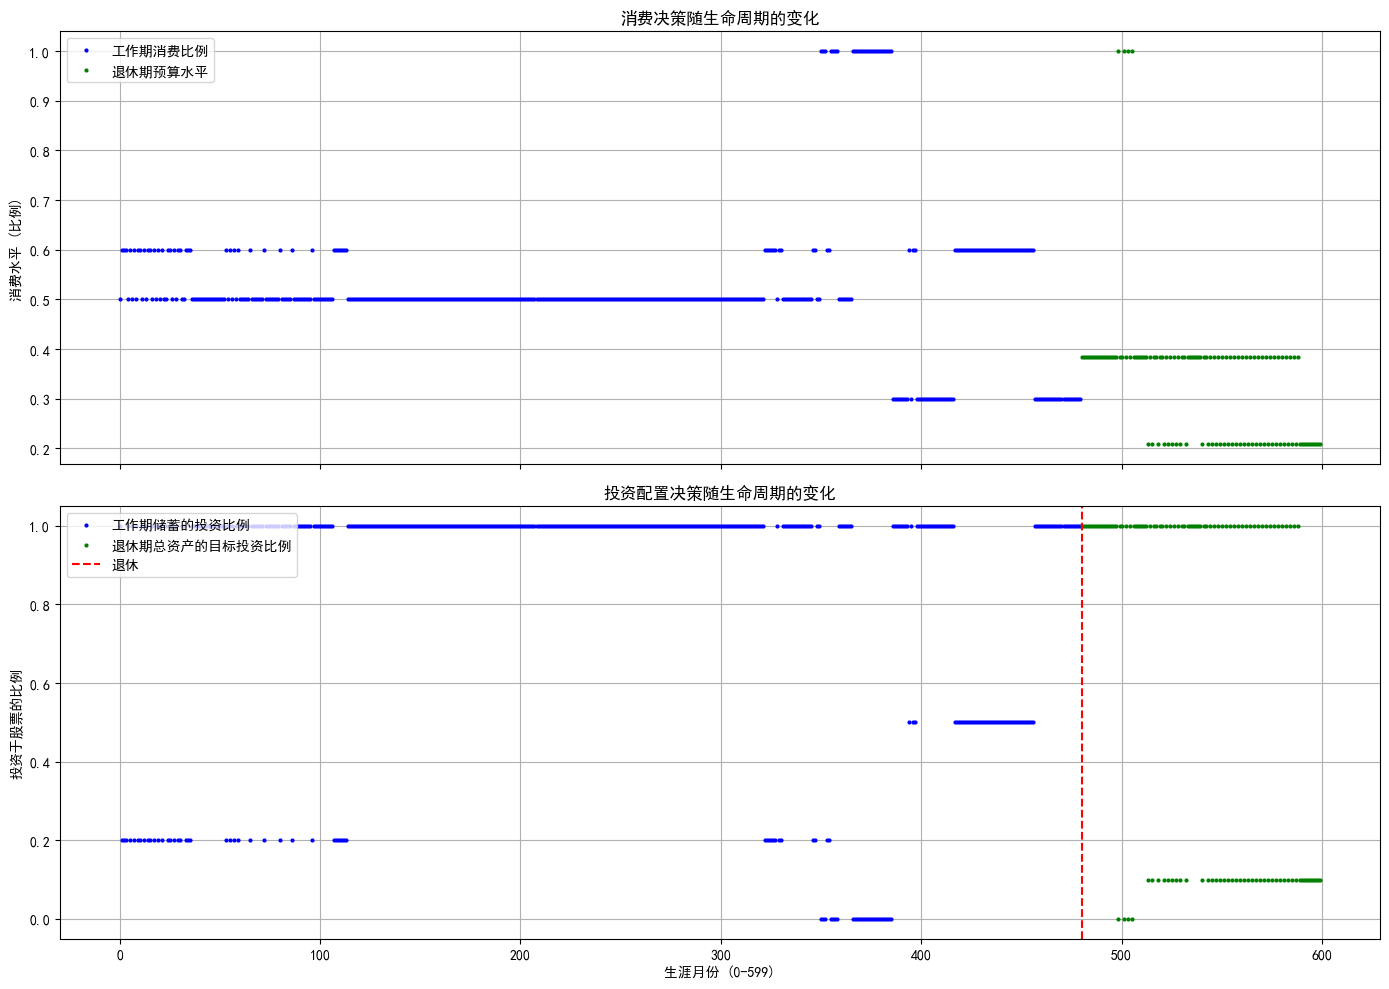

In [206]:
# 3. 评估学到的策略
actions, capital_hist, final_capital = evaluate_policy(agent, env)

# 4. 【修改】调用新的可视化函数
visualize_dual_decision_results(rewards_history, actions, capital_hist, final_capital, env)

## 加入退休选择

In [41]:
NUM_EPISODES = 1200      # 训练的总生命周期数
BUFFER_SIZE = 50000      # 经验回放池大小
alpha = 0
W_WEALTH = 0.5
W_LEISURE = 0.5
TOTAL_ACTIONS = NUM_ACTIONS + 1

class FinalDecisionEnv:
    def __init__(self):
        self.max_steps = TOTAL_MONTHS
        self.working_months = WORKING_MONTHS

        self.regular_actions_n = NUM_ACTIONS # 原有的消费/投资动作数量
        self.retire_action_index = self.regular_actions_n # “退休”动作的索引是最后一个
        self.action_space_n = self.regular_actions_n + 1 # 总动作数加一
        self.observation_space_shape = (4,)

        self.bond_monthly_return = BOND_MONTHLY_RETURN
        self.stock_avg_monthly_return = STOCK_AVG_MONTHLY_RETURN
        self.stock_monthly_volatility = STOCK_MONTHLY_VOLATILITY
        
        self.consumption_ratios = CONSUMPTION_RATIOS
        self.stock_allocation_ratios = STOCK_ALLOCATION_RATIOS
        self.retirement_budgets = RETIREMENT_BUDGETS
        
        self.bankruptcy_penalty = BANKRUPTCY_PENALTY
        self.is_retired = False # 标记是否已退休


        # NEW: 多目标奖励相关参数
        self.w_wealth = W_WEALTH
        self.w_leisure = W_LEISURE
        self.gamma = GAMMA


        self.reset()

    def get_income(self, month_index):
        return get_step_function_income(month_index)

    def reset(self):
        self.current_step = 0
        self.savings = 0.0
        self.investments = 0.0
        self.is_retired = False 
        return self._get_state()

    def _get_total_capital(self):
        return self.savings + self.investments

    def _get_state(self):
        total_capital = self._get_total_capital()
        investment_ratio = self.investments / (total_capital + 1e-6)
        norm_factor = 3_000_000
        normalized_capital = total_capital / (norm_factor + 1e-6)
        normalized_month = self.current_step / self.max_steps

        retirement_status = 1.0 if self.is_retired else 0.0
        return np.array(
            [normalized_capital, investment_ratio, normalized_month, retirement_status], 
            dtype=np.float32
        )


    def _decode_action(self, action):
        """将一维动作解码为消费和配置两个决策"""
        consumption_idx = action // NUM_ALLOCATION_LEVELS
        allocation_idx = action % NUM_ALLOCATION_LEVELS
        return consumption_idx, allocation_idx

    def _withdraw_capital(self, amount):
        """
        新增辅助函数：优先从无风险储蓄(savings)中提取资金。
        """
        if self.savings >= amount:
            self.savings -= amount
        else:
            remaining_amount = amount - self.savings
            self.savings = 0
            self.investments = max(0, self.investments - remaining_amount)
    
    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps
        info = {'shocks': []}
        reward = 0

        # 1. 市场先行：现有资产在本月增值


        self.savings *= (1 + self.bond_monthly_return)
        stock_return = np.random.normal(self.stock_avg_monthly_return, self.stock_monthly_volatility)
        if random.random() < BLACK_SWAN_PROBABILITY:
            stock_return = -0.4 # 黑天鹅事件
        self.investments = max(0, self.investments * (1 + stock_return))
        
        # 2. 新增：随机冲击事件
        # 2.1 紧急支出冲击 (任何时期都可能发生)
        if random.random() < EMERGENCY_PROBABILITY:
            # 紧急支出也遵循优先从储蓄中出的原则
            self._withdraw_capital(EMERGENCY_COST)
            info['shocks'].append('emergency')
        
        is_in_working_phase = (self.current_step <= self.working_months) and (not self.is_retired)
        
        if is_in_working_phase and action == self.retire_action_index:
            self.is_retired = True
            info['status'] = 'early_retirement'
            # 主动退休这个行为本身没有瞬时奖励或惩罚
            # 其后果（收入变为0）将在后续的步骤中自然体现
            reward = 0
            is_in_working_phase = False # 立即更新状态，本月进入退休模式

        if is_in_working_phase:
            # --- 模式一: 工作期 ---
            # 这个分支的逻辑和原来完全一样
            # 注意：只有当 action 不是“退休”时才会进入这里
            consumption_idx, allocation_idx = self._decode_action(action)
            base_income = self.get_income(self.current_step - 1)
            
            if random.random() < JOB_LOSS_PROBABILITY and base_income > 0:
                current_income = 0
                info['shocks'].append('job_loss')
            else:
                current_income = base_income
            
            consumption_ratio = self.consumption_ratios[consumption_idx]
            amount_consumed = current_income * consumption_ratio
            amount_saved_total = current_income * (1 - consumption_ratio)
            reward = math.log(amount_consumed + 1)
            
            stock_allocation_ratio = self.stock_allocation_ratios[allocation_idx]
            to_invest = amount_saved_total * stock_allocation_ratio
            to_save_risk_free = amount_saved_total * (1 - stock_allocation_ratio)
            
            self.savings += to_save_risk_free
            self.investments += to_invest
        else:
            # --- 模式二: 退休期 ---
            # （无论是正常退休还是主动退休，都进入此逻辑）
            # 这个分支的逻辑和原来也完全一样
            if action < self.regular_actions_n: # 确保解码的动作是常规动作
                consumption_idx, allocation_idx = self._decode_action(action)
            else: # 如果在退休期收到了“退休”动作，当成一个无效/默认动作处理
                consumption_idx, allocation_idx = 0, 0 # 例如，选择最保守的策略

            total_capital = self._get_total_capital()
            budget_choice = self.retirement_budgets[consumption_idx]
            
            if total_capital >= budget_choice:
                amount_consumed = budget_choice
                reward = math.log(amount_consumed + 1)
                self._withdraw_capital(amount_consumed)
            else: # 破产
                reward = math.log(max(1, total_capital + 1)) + self.bankruptcy_penalty
                self.savings, self.investments = 0, 0
                info['status'] = 'bankrupt'
                done = True

            if not info.get('status') == 'bankrupt':
                target_stock_allocation = self.stock_allocation_ratios[allocation_idx]
                current_total_capital = self._get_total_capital()
                target_investment_value = current_total_capital * target_stock_allocation
                
                transfer_to_investments = target_investment_value - self.investments
                self.investments += transfer_to_investments
                self.savings -= transfer_to_investments

        # 6. 最终奖励计算（和原来一样）
        if done and not info.get('status') == 'bankrupt':
            reward += math.log(self._get_total_capital() + 1) * alpha
            
        next_state = self._get_state()
        return next_state, reward, done, info
    
def evaluate_policy(agent, env):
    """
    评估训练好的 DQNAgent 在 DualDecisionEnv 环境中的策略。
    【已修改】现在会额外返回实际的退休月份。
    
    Args:
        agent (DQNAgent): 训练好的 agent。
        env (DualDecisionEnv): 环境对象。
        
    Returns:
        tuple: (actions_taken, portfolio_history, final_capital, retirement_month)
            - actions_taken (list): 采取的动作列表。
            - portfolio_history (list): 每个时间点的详细资产组合列表。
            - final_capital (float): 最终的总资产。
            - retirement_month (int or None): 实际发生退休的月份。如果未退休则为 None。
    """
    print("\n--- 正在执行学习到的最优策略 ---")
    
    state = env.reset()
    agent.epsilon = 0.0

    actions_taken = []
    portfolio_history = []
    retirement_month = None  # <--- NEW: 初始化退休月份变量

    initial_capital = env._get_total_capital()
    portfolio_history.append((initial_capital, env.savings, env.investments))

    for t in range(env.max_steps):
        action = agent.choose_action(state)
        actions_taken.append(action)
        
        next_state, _, done, info = env.step(action)
        
        # <--- NEW: 捕获提前退休事件 --->
        if info.get('status') == 'early_retirement' and retirement_month is None:
            retirement_month = t + 1 # t 从 0 开始，所以月份是 t+1
        
        state = next_state
        
        current_total_capital = env._get_total_capital()
        portfolio_history.append((current_total_capital, env.savings, env.investments))
        
        if done:
            status = info.get('status', '达到最大时长')
            print(f"评估在第 {t+1} 个月结束。原因: {status}")
            break
            
    final_capital = portfolio_history[-1][0]
    
    # <--- MODIFIED: 在返回值中增加 retirement_month --->
    return actions_taken, portfolio_history, final_capital, retirement_month

def visualize_dual_decision_results(
    rewards_history,
    actions_taken,
    portfolio_history,
    final_capital_result,
    env,
    retirement_month=None  # <--- NEW: 接收 retirement_month 参数
):
    """
    为双重决策环境设计的可视化函数。
    【已修改】现在能动态显示实际退休时间。
    """
    print(f"\n--- 策略评估结果 ---")
    print(f"评估在第 {len(actions_taken)} 个月结束。")
    if retirement_month:
        print(f"智能体在第 {retirement_month} 个月选择提前退休。")
    print(f"最终总资产: ${final_capital_result:,.2f}")

    # --- 图1: 训练奖励曲线 (保持不变) ---
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_history, alpha=0.6, label='每轮奖励')
    if len(rewards_history) >= 50:
        moving_avg = np.convolve(rewards_history, np.ones(50)/50, mode='valid')
        plt.plot(moving_avg, color='red', linewidth=2, label='移动平均 (50轮)')
    plt.title("训练期间每轮累计效用（奖励）")
    plt.xlabel("生命周期 (Episode)")
    plt.ylabel("累计效用")
    plt.grid(True)
    plt.legend()
    plt.show()

    # <--- MODIFIED: 从这里开始，使用 retirement_month 动态调整图表 --->
    
    # 确定实际的退休分界点
    # 如果没有提前退休，且模拟时长超过了默认工作月数，则使用默认值
    if retirement_month is None and len(actions_taken) > env.working_months:
        actual_retirement_point = env.working_months
        retirement_label = f'法定退休 (第{env.working_months}月)'
    elif retirement_month is not None:
        actual_retirement_point = retirement_month
        retirement_label = f'提前退休 (第{retirement_month}月)'
    else:
        actual_retirement_point = None # 未达到任何退休点
        retirement_label = ''

    # --- 图2: 财富与资产配置随时间变化 ---
    total_capital_hist, savings_hist, investments_hist = zip(*portfolio_history)
    stock_ratio_hist = [inv / (cap + 1e-6) for inv, cap in zip(investments_hist, total_capital_hist)]
    x_axis_range = range(len(total_capital_hist))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    ax1.stackplot(x_axis_range, savings_hist, investments_hist, 
                  labels=['储蓄金 (无风险)', '投资金 (风险)'],
                  colors=['skyblue', 'salmon'])
    ax1.plot(x_axis_range, total_capital_hist, color='black', linewidth=2, label='总资产')
    ax1.set_title("财富增长与资产构成")
    ax1.set_ylabel("资产 ($)")
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2.plot(x_axis_range, stock_ratio_hist, color='purple', label='股票占总资产比例')
    ax2.set_title("投资组合风险暴露（股票占比）")
    ax2.set_xlabel(f"生涯月份 (0-{len(actions_taken)})")
    ax2.set_ylabel("股票占比")
    ax2.set_ylim([0, 1.05])
    if actual_retirement_point: # 如果存在退休点，则画线
        ax2.axvline(x=actual_retirement_point, color='r', linestyle='--', label=retirement_label)
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    # --- 图3: 决策行为分析 ---
    num_allocations = env.regular_actions_n // NUM_CONSUMPTION_LEVELS # 使用 regular_actions_n
    
    # 【核心修改】根据 actual_retirement_point 来分割工作期和退休期
    split_point = actual_retirement_point if actual_retirement_point else len(actions_taken)
    
    # 过滤掉“退休”这个特殊动作，只分析常规决策
    regular_actions = [(t, a) for t, a in enumerate(actions_taken) if a < env.regular_actions_n]
    if not regular_actions:
        print("未记录任何常规决策，无法生成决策分析图。")
        return

    time_indices, action_values = zip(*regular_actions)
    
    working_time = [t for t, a in regular_actions if t < split_point]
    working_actions = [a for t, a in regular_actions if t < split_point]
    
    retirement_time = [t for t, a in regular_actions if t >= split_point]
    retirement_actions = [a for t, a in regular_actions if t >= split_point]

    working_consumption_ratios = [env.consumption_ratios[a // num_allocations] for a in working_actions]
    working_allocation_ratios = [env.stock_allocation_ratios[a % num_allocations] for a in working_actions]
    
    fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # 上图：消费决策
    ax3.plot(working_time, working_consumption_ratios, 
             'bo', markersize=2, label='工作期消费比例')
    if retirement_actions:
        retirement_budgets = [env.retirement_budgets[a // num_allocations] for a in retirement_actions]
        retirement_consumption_as_ratio = [b / np.max(env.retirement_budgets) for b in retirement_budgets]
        ax3.plot(retirement_time, retirement_consumption_as_ratio,
                 'go', markersize=2, label='退休期预算水平')
    ax3.set_title("消费决策随生命周期的变化")
    ax3.set_ylabel("消费水平 (比例)")
    if actual_retirement_point:
        ax3.axvline(x=actual_retirement_point, color='r', linestyle='--', label=retirement_label)
    ax3.legend(loc='upper left')
    ax3.grid(True)

    # 下图：投资配置决策
    ax4.plot(working_time, working_allocation_ratios, 
             'bo', markersize=2, label='工作期储蓄的投资比例')
    if retirement_actions:
        retirement_rebalance_targets = [env.stock_allocation_ratios[a % num_allocations] for a in retirement_actions]
        ax4.plot(retirement_time, retirement_rebalance_targets, 
                 'go', markersize=2, label='退休期总资产的目标投资比例')
    ax4.set_title("投资配置决策随生命周期的变化")
    ax4.set_xlabel(f"生涯月份 (0-{len(actions_taken)})")
    ax4.set_ylabel("投资于股票的比例")
    if actual_retirement_point:
        ax4.axvline(x=actual_retirement_point, color='r', linestyle='--', label=retirement_label)
    ax4.legend(loc='upper left')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    

In [ ]:
if __name__ == '__main__':
    # 1. 初始化环境和Agent
    env = FinalDecisionEnv() # 使用新的环境
    agent = DQNAgent(state_size=env.observation_space_shape[0], action_size=env.action_space_n)
    
    # 2. 训练Agent
    rewards_history = train_agent(agent, env, NUM_EPISODES, TARGET_UPDATE_FREQ)


--- 正在执行学习到的最优策略 ---
评估在第 600 个月结束。原因: 达到最大时长

--- 策略评估结果 ---
评估在第 600 个月结束。
最终总资产: $2,192,397.79


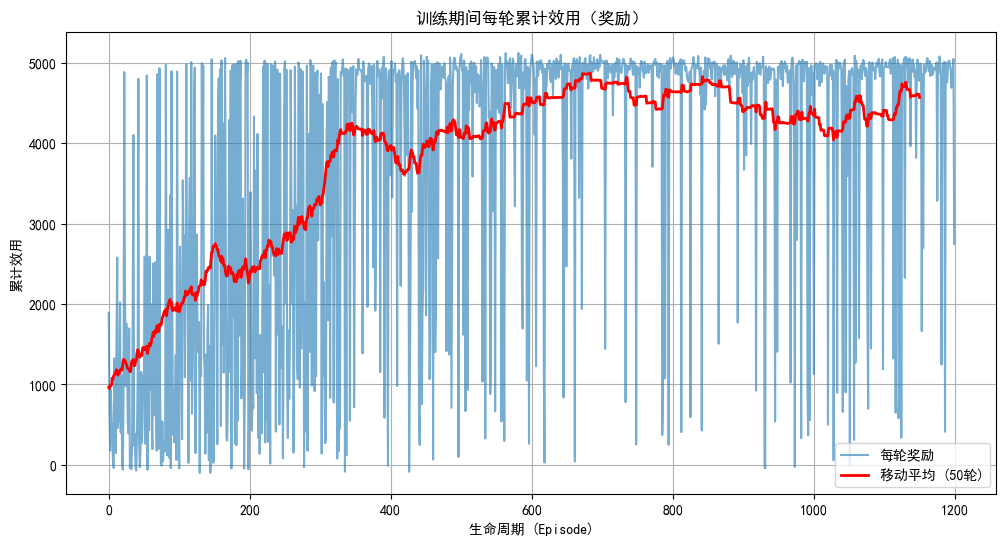

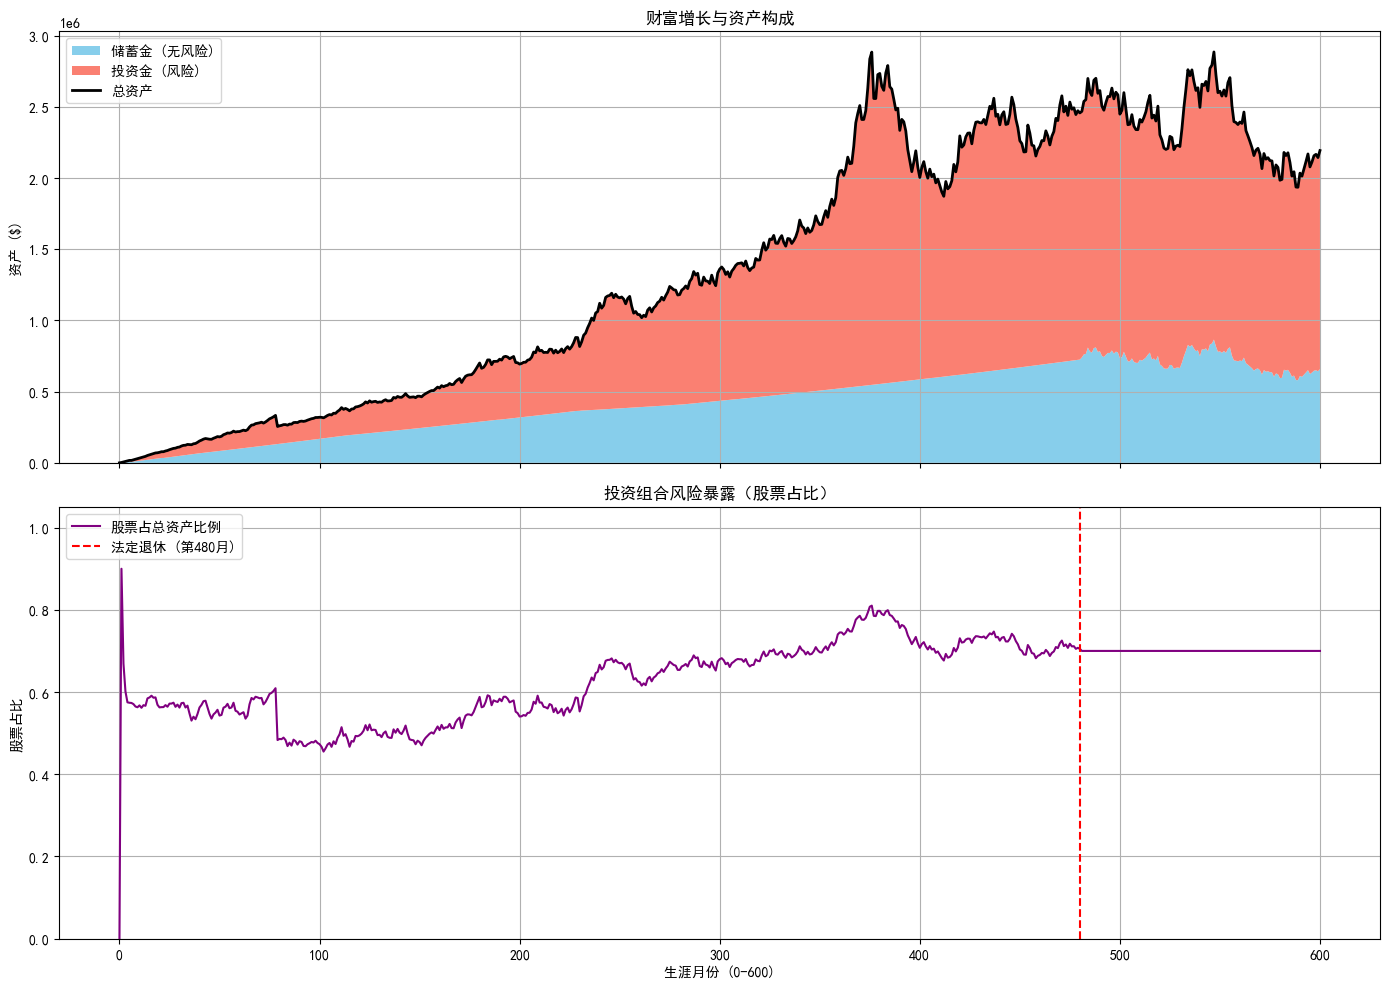

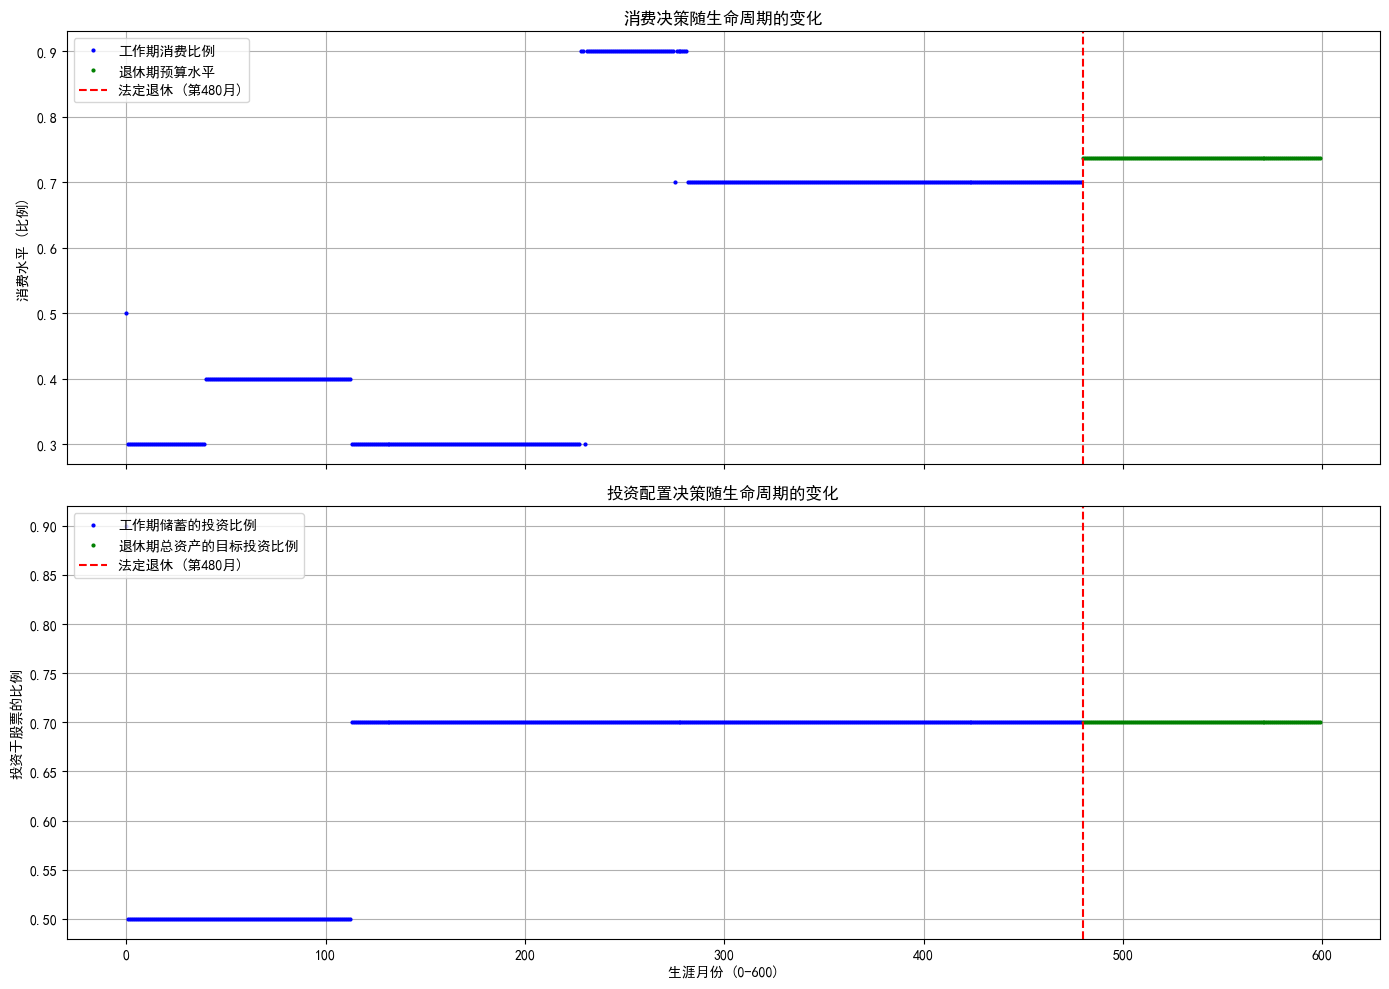

In [221]:
# 3. 评估学到的策略
actions, portfolio_hist, final_cap, retirement_m = evaluate_policy(agent, env)

# 4. 【修改】调用新的可视化函数
visualize_dual_decision_results(
    rewards_history,    # 假设这是您从训练中得到的奖励历史
    actions,
    portfolio_hist,
    final_cap,
    env,
    retirement_m        # 传入新的退休月份参数
)

In [ ]:
print(retirement_m)

In [36]:
RETIREMENT_BONUS_PER_MONTH = np.log(5000)
NUM_EPISODES = 4000      # 训练的总生命周期数
BUFFER_SIZE = 50000      # 经验回放池大小

class FinalDecisionEnv:
    def __init__(self):
        self.max_steps = TOTAL_MONTHS
        self.working_months = WORKING_MONTHS

        self.regular_actions_n = NUM_ACTIONS # 原有的消费/投资动作数量
        self.retire_action_index = self.regular_actions_n # “退休”动作的索引是最后一个
        self.action_space_n = self.regular_actions_n + 1 # 总动作数加一
        self.observation_space_shape = (4,)

        self.bond_monthly_return = BOND_MONTHLY_RETURN
        self.stock_avg_monthly_return = STOCK_AVG_MONTHLY_RETURN
        self.stock_monthly_volatility = STOCK_MONTHLY_VOLATILITY
        
        self.consumption_ratios = CONSUMPTION_RATIOS
        self.stock_allocation_ratios = STOCK_ALLOCATION_RATIOS
        self.retirement_budgets = RETIREMENT_BUDGETS
        
        self.bankruptcy_penalty = BANKRUPTCY_PENALTY
        self.is_retired = False # 标记是否已退休

        self.retirement_bonus = RETIREMENT_BONUS_PER_MONTH

        # NEW: 多目标奖励相关参数
        self.w_wealth = W_WEALTH
        self.w_leisure = W_LEISURE
        self.gamma = GAMMA


        self.reset()

    def get_income(self, month_index):
        return get_step_function_income(month_index)

    def reset(self):
        self.current_step = 0
        self.savings = 0.0
        self.investments = 0.0
        self.is_retired = False 
        return self._get_state()

    def _get_total_capital(self):
        return self.savings + self.investments

    def _get_state(self):
        total_capital = self._get_total_capital()
        investment_ratio = self.investments / (total_capital + 1e-6)
        norm_factor = 3_000_000
        normalized_capital = total_capital / (norm_factor + 1e-6)
        normalized_month = self.current_step / self.max_steps

        retirement_status = 1.0 if self.is_retired else 0.0
        return np.array(
            [normalized_capital, investment_ratio, normalized_month, retirement_status], 
            dtype=np.float32
        )


    def _decode_action(self, action):
        """将一维动作解码为消费和配置两个决策"""
        consumption_idx = action // NUM_ALLOCATION_LEVELS
        allocation_idx = action % NUM_ALLOCATION_LEVELS
        return consumption_idx, allocation_idx

    def _withdraw_capital(self, amount):
        """
        新增辅助函数：优先从无风险储蓄(savings)中提取资金。
        """
        if self.savings >= amount:
            self.savings -= amount
        else:
            remaining_amount = amount - self.savings
            self.savings = 0
            self.investments = max(0, self.investments - remaining_amount)
    
    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps
        info = {'shocks': []}
        reward = 0

        # 1. 市场先行：现有资产在本月增值


        self.savings *= (1 + self.bond_monthly_return)
        stock_return = np.random.normal(self.stock_avg_monthly_return, self.stock_monthly_volatility)
        if random.random() < BLACK_SWAN_PROBABILITY:
            stock_return = -0.4 # 黑天鹅事件
        self.investments = max(0, self.investments * (1 + stock_return))
        
        # 2. 新增：随机冲击事件
        # 2.1 紧急支出冲击 (任何时期都可能发生)
        if random.random() < EMERGENCY_PROBABILITY:
            # 紧急支出也遵循优先从储蓄中出的原则
            self._withdraw_capital(EMERGENCY_COST)
            info['shocks'].append('emergency')
        
        is_in_working_phase = (self.current_step <= self.working_months) and (not self.is_retired)
        
        if is_in_working_phase and action == self.retire_action_index:
            self.is_retired = True
            info['status'] = 'early_retirement'
            # 主动退休这个行为本身没有瞬时奖励或惩罚
            # 其后果（收入变为0）将在后续的步骤中自然体现
            reward = 0
            is_in_working_phase = False # 立即更新状态，本月进入退休模式

        if is_in_working_phase:
            # --- 模式一: 工作期 ---
            # 这个分支的逻辑和原来完全一样
            # 注意：只有当 action 不是“退休”时才会进入这里
            consumption_idx, allocation_idx = self._decode_action(action)
            base_income = self.get_income(self.current_step - 1)
            
            if random.random() < JOB_LOSS_PROBABILITY and base_income > 0:
                current_income = 0
                info['shocks'].append('job_loss')
            else:
                current_income = base_income
            
            consumption_ratio = self.consumption_ratios[consumption_idx]
            amount_consumed = current_income * consumption_ratio
            amount_saved_total = current_income * (1 - consumption_ratio)
            reward = math.log(amount_consumed + 1)
            
            stock_allocation_ratio = self.stock_allocation_ratios[allocation_idx]
            to_invest = amount_saved_total * stock_allocation_ratio
            to_save_risk_free = amount_saved_total * (1 - stock_allocation_ratio)
            
            self.savings += to_save_risk_free
            self.investments += to_invest
        else:
            # --- 模式二: 退休期 ---
            # （无论是正常退休还是主动退休，都进入此逻辑）
            # 这个分支的逻辑和原来也完全一样
            if action < self.regular_actions_n: # 确保解码的动作是常规动作
                consumption_idx, allocation_idx = self._decode_action(action)
            else: # 如果在退休期收到了“退休”动作，当成一个无效/默认动作处理
                consumption_idx, allocation_idx = 0, 0 # 例如，选择最保守的策略

            total_capital = self._get_total_capital()
            budget_choice = self.retirement_budgets[consumption_idx]
            
            if total_capital >= budget_choice:
                amount_consumed = budget_choice
                reward = math.log(amount_consumed + 1) + self.retirement_bonus # 仅仅加上退休奖励
                self._withdraw_capital(amount_consumed)
            else: # 破产
                reward = math.log(max(1, total_capital + 1)) + self.bankruptcy_penalty
                self.savings, self.investments = 0, 0
                info['status'] = 'bankrupt'
                done = True

            if not info.get('status') == 'bankrupt':
                target_stock_allocation = self.stock_allocation_ratios[allocation_idx]
                current_total_capital = self._get_total_capital()
                target_investment_value = current_total_capital * target_stock_allocation
                
                transfer_to_investments = target_investment_value - self.investments
                self.investments += transfer_to_investments
                self.savings -= transfer_to_investments

        # 6. 最终奖励计算（和原来一样）
        if done and not info.get('status') == 'bankrupt':
            reward += math.log(self._get_total_capital() + 1) * alpha
            
        next_state = self._get_state()
        return next_state, reward, done, info

In [37]:
if __name__ == '__main__':
    # 1. 初始化环境和Agent
    env = FinalDecisionEnv() # 使用新的环境
    agent = DQNAgent(state_size=env.observation_space_shape[0], action_size=env.action_space_n)
    
    # 2. 训练Agent
    rewards_history = train_agent(agent, env, NUM_EPISODES, TARGET_UPDATE_FREQ)

开始训练...
Episode 10/4000 | 总奖励: -100.00 | Epsilon: 0.9511
Episode 20/4000 | 总奖励: 328.85 | Epsilon: 0.9046
Episode 30/4000 | 总奖励: 29.68 | Epsilon: 0.8604
Episode 40/4000 | 总奖励: -100.00 | Epsilon: 0.8183
Episode 50/4000 | 总奖励: 1178.67 | Epsilon: 0.7783
Episode 60/4000 | 总奖励: 8476.06 | Epsilon: 0.7403
Episode 70/4000 | 总奖励: 292.97 | Epsilon: 0.7041
Episode 80/4000 | 总奖励: 44.60 | Epsilon: 0.6696
Episode 90/4000 | 总奖励: 30.13 | Epsilon: 0.6369
Episode 100/4000 | 总奖励: 169.03 | Epsilon: 0.6058
Episode 110/4000 | 总奖励: 181.56 | Epsilon: 0.5762
Episode 120/4000 | 总奖励: 211.99 | Epsilon: 0.5480
Episode 130/4000 | 总奖励: -100.00 | Epsilon: 0.5212
Episode 140/4000 | 总奖励: -100.00 | Epsilon: 0.4957
Episode 150/4000 | 总奖励: 139.60 | Epsilon: 0.4715
Episode 160/4000 | 总奖励: 44.09 | Epsilon: 0.4484
Episode 170/4000 | 总奖励: 43.93 | Epsilon: 0.4265
Episode 180/4000 | 总奖励: -100.00 | Epsilon: 0.4057
Episode 190/4000 | 总奖励: 182.06 | Epsilon: 0.3858
Episode 200/4000 | 总奖励: 29.61 | Epsilon: 0.3670
Episode 210/4000 | 总


--- 正在执行学习到的最优策略 ---
评估在第 600 个月结束。原因: 达到最大时长

--- 策略评估结果 ---
评估在第 600 个月结束。
智能体在第 287 个月选择提前退休。
最终总资产: $3,044,739.57


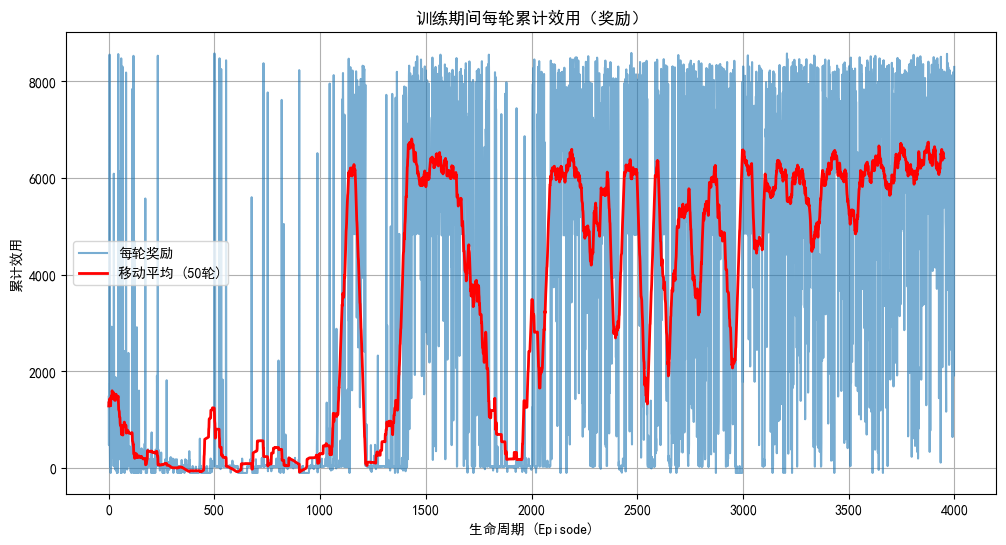

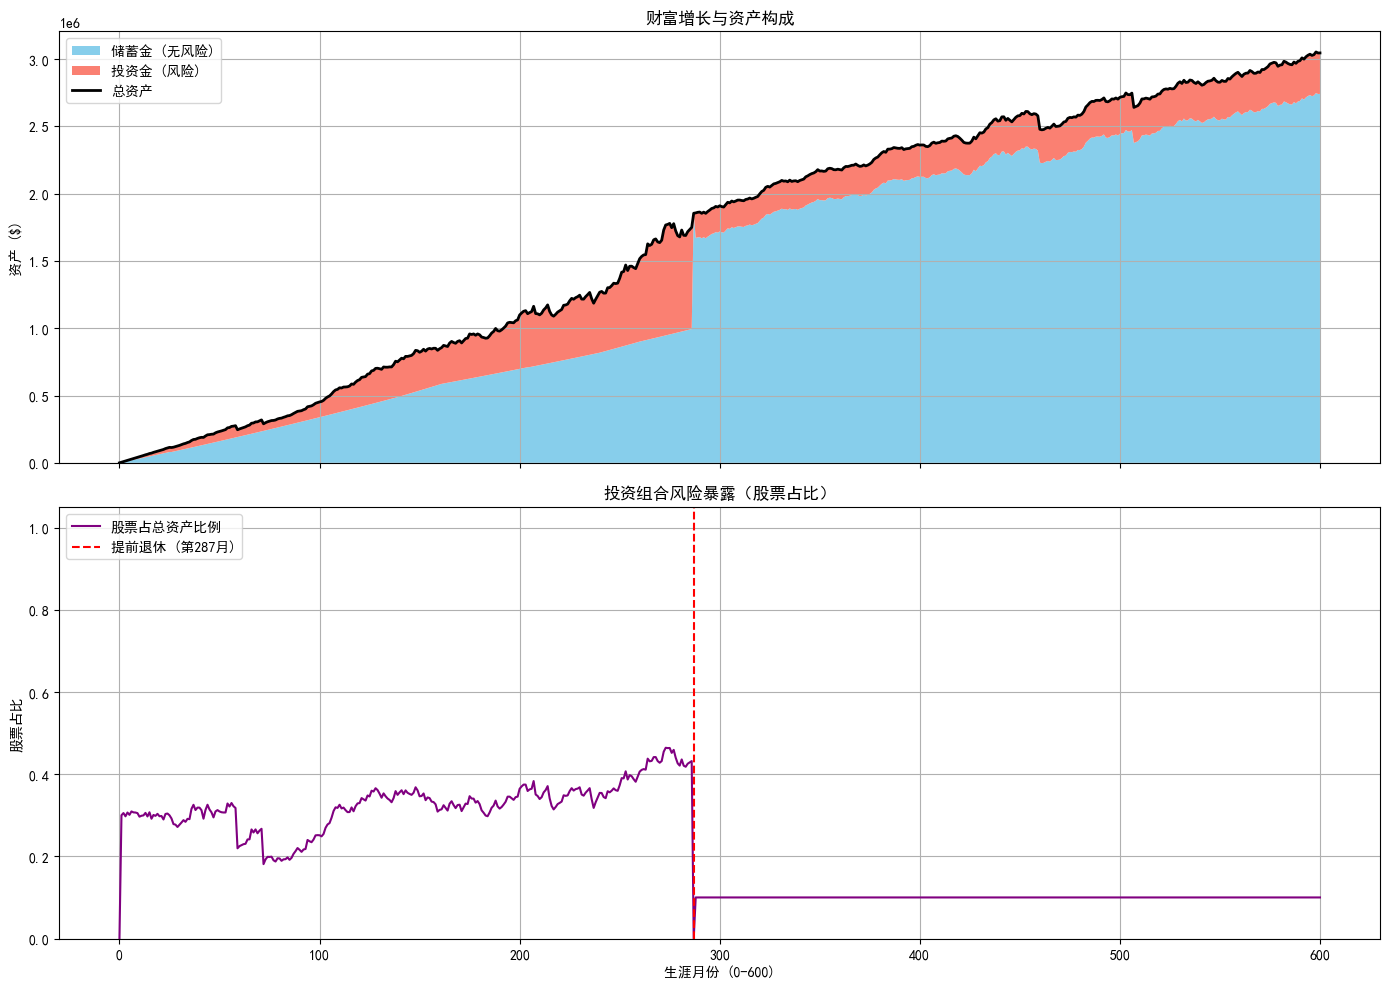

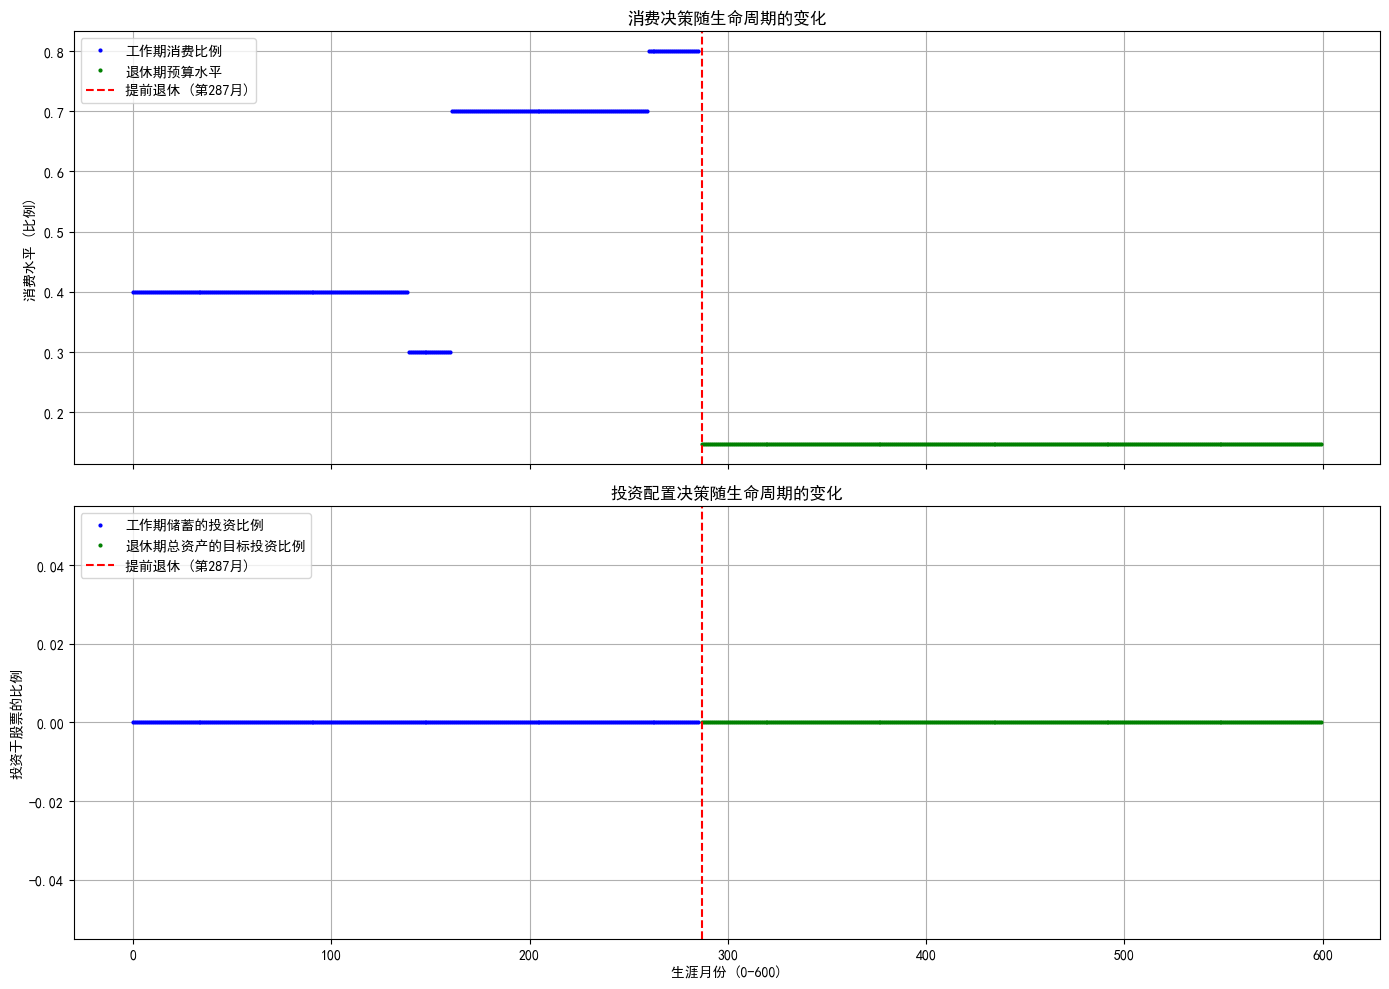

In [42]:
# 3. 评估学到的策略
actions, portfolio_hist, final_cap, retirement_m = evaluate_policy(agent, env)

# 4. 【修改】调用新的可视化函数
visualize_dual_decision_results(
    rewards_history,    # 假设这是您从训练中得到的奖励历史
    actions,
    portfolio_hist,
    final_cap,
    env,
    retirement_m        # 传入新的退休月份参数
)

In [43]:
print(retirement_m)

287
